In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [2]:
#To display all the columns and rows
pd.set_option('display.max_columns', 1000);
pd.set_option('display.max_rows', 1000);
pd.set_option('display.width', 1000);
#To ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#To supress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#Loading the file
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/eda_disorders.csv')

In [4]:
#Creating deep copies of the dataframe
df1 = df.copy(deep=True)
df2 = df.copy(deep=True)
df3 = df.copy(deep=True)
df4 = df.copy(deep=True)
df5 = df.copy(deep=True)
df6 = df.copy(deep=True)
df7 = df.copy(deep=True)
df8 = df.copy(deep=True)

In [5]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56917 entries, 0 to 56916
Data columns (total 374 columns):
 #    Column                                           Non-Null Count  Dtype  
---   ------                                           --------------  -----  
 0    subject_id                                       56917 non-null  int64  
 1    hadm_id                                          56917 non-null  int64  
 2    procedures_applied                               30277 non-null  object 
 3    icd_code                                         56917 non-null  object 
 4    long_title                                       56917 non-null  object 
 5    seq_num                                          56917 non-null  int64  
 6    Classification                                   56917 non-null  object 
 7    included                                         56917 non-null  object 
 8    class                                            56917 non-null  int64  
 9    gender         

## 1. Why Rare Skin Diseases?

In [6]:
#Create a copy of the dataframe and split classifications
df1['classification_list'] = df1['Classification'].str.split(', ')

#Explode so that each row is a (subject_id, single classification) pair
exploded = df1[['subject_id', 'classification_list']].explode('classification_list')

#Simplified 10-group category mapping
simplified_category_mapping = {

    'rare_neurological_diseases': 'Neurological & Developmental',
    'rare_developmental_anomalies_during_embryogenesis': 'Neurological & Developmental',
    'rare_disorder_without_a_determined_diagnosis_after_full_investigation': 'Neurological & Developmental',

    'rare_hematological_diseases': 'Hematological & Immunological',
    'rare_immunological_diseases': 'Hematological & Immunological',
    'rare_neoplastic_diseases': 'Hematological & Immunological',

    'rare_endocrine_diseases': 'Endocrine, Metabolic & Genetic',
    'rare_inborn_errors_of_metabolism': 'Endocrine, Metabolic & Genetic',
    'rare_genetic_diseases': 'Endocrine, Metabolic & Genetic',

    'rare_gastroenterological_diseases': 'Digestive & Hepatic',
    'rare_hepatic_diseases': 'Digestive & Hepatic',

    'rare_cardiac_diseases': 'Cardiovascular',
    'rare_circulatory_system_diseases': 'Cardiovascular',

    'rare_respiratory_diseases': 'Respiratory',
    'rare_surgical_thoracic_diseases': 'Respiratory',

    'rare_bone_diseases': 'Musculoskeletal & Rheumatologic',
    'rare_systemic_and_rheumatological_diseases': 'Musculoskeletal & Rheumatologic',
    'rare_systemic_and_rheumatological_diseases_of_childhood': 'Musculoskeletal & Rheumatologic',

    'rare_skin_diseases': 'Dermatological',

    'rare_urogenital_diseases': 'Urogenital',
    'rare_renal_diseases': 'Urogenital',
    'rare_infertility_disorders': 'Urogenital',
    'rare_gynecological_and_obstetric_diseases': 'Urogenital',

    'rare_ophthalmic_diseases': 'Head & Neck',
    'rare_otorhinolaryngological_diseases': 'Head & Neck',
    'rare_surgical_maxillo-facial_diseases': 'Head & Neck',
    'rare_odontological_diseases': 'Head & Neck',

    'rare_infectious_diseases': 'Other',
    'rare_abdominal_surgical_diseases': 'Other',
    'rare_transplant-related_diseases': 'Other',
    'rare_diseases_due_to_toxic_effects': 'Other',
    'Uncategorised': 'Uncategorized'
}

#Map to simplified categories
exploded['Simplified_Category'] = exploded['classification_list'].map(simplified_category_mapping)

#Drop duplicates so each subject appears only once per category
unique_patient_category = exploded.drop_duplicates(subset=['subject_id', 'Simplified_Category'])

#Count number of unique patients per category
category_counts = (
    unique_patient_category['Simplified_Category']
    .value_counts()
    .reset_index()
    .rename(columns={'count': 'Unique_Patient_Count'})
    .sort_values('Unique_Patient_Count', ascending=False)
)

In [7]:
category_counts

Simplified_Category  Unique_Patient_Count
0    Endocrine, Metabolic & Genetic                 14006
1     Hematological & Immunological                  6096
2                             Other                  5196
3      Neurological & Developmental                  5191
4                    Cardiovascular                  4526
5               Digestive & Hepatic                  4452
6                        Urogenital                  2960
7                     Uncategorized                  2202
8   Musculoskeletal & Rheumatologic                  1721
9                    Dermatological                  1415
10                      Head & Neck                  1240
11                      Respiratory                  1214

In [8]:
#Extract subject_id + hospital_expire_flag from original df
death_info = df1[['subject_id', 'is_dead']].drop_duplicates()

#Join with exploded table (which has subject_id + Simplified_Category)
exploded_with_death = exploded.merge(death_info, on='subject_id', how='left')

#Drop duplicates (subject_id + category) to avoid multi-counting per category
unique_death_category = exploded_with_death.drop_duplicates(subset=['subject_id', 'Simplified_Category'])

#Group by category and sum deaths
death_counts = (
    unique_death_category
    .groupby('Simplified_Category')['is_dead']
    .sum()
    .reset_index()
    .rename(columns={'is_dead': 'Death_Count'})
)

#Merge death counts into your category_counts table
category_counts = category_counts.merge(death_counts, on='Simplified_Category', how='left')

#Add mortality rate
category_counts['Mortality_Rate (%)'] = (
    100 * category_counts['Death_Count'] / category_counts['Unique_Patient_Count']
).round(2)

#Final output
print(category_counts)

                Simplified_Category  Unique_Patient_Count  Death_Count  Mortality_Rate (%)
0    Endocrine, Metabolic & Genetic                 14006         2752              19.650
1     Hematological & Immunological                  6096         2126              34.880
2                             Other                  5196         1428              27.480
3      Neurological & Developmental                  5191          834              16.070
4                    Cardiovascular                  4526         1027              22.690
5               Digestive & Hepatic                  4452         1333              29.940
6                        Urogenital                  2960          575              19.430
7                     Uncategorized                  2202          173               7.860
8   Musculoskeletal & Rheumatologic                  1721          264              15.340
9                    Dermatological                  1415          354              25.020

In [9]:
# Step 1: Count number of diagnoses per row
df1['num_diagnoses'] = df1['icd_code_list'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

# Step 2: Extract subject_id and num_diagnoses per admission
diagnosis_info = df1[['subject_id', 'num_diagnoses']].drop_duplicates()

# Step 3: Merge diagnosis info with the exploded category table
exploded_with_diag = exploded.merge(diagnosis_info, on='subject_id', how='left')

# Step 4: Drop duplicate (subject_id + Simplified_Category) to avoid overcounting
unique_diag_category = exploded_with_diag.drop_duplicates(subset=['subject_id', 'Simplified_Category'])

# Step 5: Compute average number of diagnoses per category
avg_diagnosis = (
    unique_diag_category
    .groupby('Simplified_Category')['num_diagnoses']
    .mean()
    .reset_index()
    .rename(columns={'num_diagnoses': 'Avg_Num_Diagnoses'})
)

# Optional: round to 2 decimal places
avg_diagnosis['Avg_Num_Diagnoses'] = avg_diagnosis['Avg_Num_Diagnoses'].round(2)

# Step 6: Merge into category_counts
category_counts = category_counts.merge(avg_diagnosis, on='Simplified_Category', how='left')

# Final output
print(category_counts)

                Simplified_Category  Unique_Patient_Count  Death_Count  Mortality_Rate (%)  Avg_Num_Diagnoses
0    Endocrine, Metabolic & Genetic                 14006         2752              19.650              2.440
1     Hematological & Immunological                  6096         2126              34.880              2.480
2                             Other                  5196         1428              27.480              2.610
3      Neurological & Developmental                  5191          834              16.070              2.130
4                    Cardiovascular                  4526         1027              22.690              2.720
5               Digestive & Hepatic                  4452         1333              29.940              2.550
6                        Urogenital                  2960          575              19.430              2.310
7                     Uncategorized                  2202          173               7.860              1.070
8   Muscul

In [10]:
# Step 1: Get subject_id + los (length of stay) per admission
los_info = df1[['subject_id', 'los']].drop_duplicates()

# Step 2: Merge LOS info with exploded category table
exploded_with_los = exploded.merge(los_info, on='subject_id', how='left')

# Step 3: Drop duplicates so each patient contributes only once per category
unique_los_category = exploded_with_los.drop_duplicates(subset=['subject_id', 'Simplified_Category'])

# Step 4: Group by category and compute average LOS
avg_los = (
    unique_los_category
    .groupby('Simplified_Category')['los']
    .mean()
    .reset_index()
    .rename(columns={'los': 'Avg_LOS'})
)

# Optional: round to 2 decimal places
avg_los['Avg_LOS'] = avg_los['Avg_LOS'].round(2)

# Step 5: Merge with your main summary table
category_counts = category_counts.merge(avg_los, on='Simplified_Category', how='left')

# Final output
print(category_counts)

                Simplified_Category  Unique_Patient_Count  Death_Count  Mortality_Rate (%)  Avg_Num_Diagnoses  Avg_LOS
0    Endocrine, Metabolic & Genetic                 14006         2752              19.650              2.440    5.920
1     Hematological & Immunological                  6096         2126              34.880              2.480    7.430
2                             Other                  5196         1428              27.480              2.610    7.580
3      Neurological & Developmental                  5191          834              16.070              2.130    5.710
4                    Cardiovascular                  4526         1027              22.690              2.720    7.310
5               Digestive & Hepatic                  4452         1333              29.940              2.550    6.520
6                        Urogenital                  2960          575              19.430              2.310    5.670
7                     Uncategorized             

In [11]:
#Extract subject_id + medications + lab tests from original df
med_lab_info = df1[['subject_id', 'num_prescriptions_drugs', 'total_lab_tests']].drop_duplicates()

#Merge with exploded table to link with Simplified_Category
exploded_with_medlab = exploded.merge(med_lab_info, on='subject_id', how='left')

#Drop duplicates to avoid overcounting
unique_medlab_category = exploded_with_medlab.drop_duplicates(subset=['subject_id', 'Simplified_Category'])

#Group and compute average values
avg_medlab = (
    unique_medlab_category
    .groupby('Simplified_Category')[['num_prescriptions_drugs', 'total_lab_tests']]
    .mean()
    .reset_index()
    .rename(columns={
        'num_prescriptions_drugs': 'Avg_Num_Medications',
        'total_lab_tests': 'Avg_Num_Lab_Tests'
    })
)

#round to 2 decimals
avg_medlab['Avg_Num_Medications'] = avg_medlab['Avg_Num_Medications'].round(2)
avg_medlab['Avg_Num_Lab_Tests'] = avg_medlab['Avg_Num_Lab_Tests'].round(2)

#Merge into final summary table
category_counts = category_counts.merge(avg_medlab, on='Simplified_Category', how='left')

# Final output
print(category_counts)

                Simplified_Category  Unique_Patient_Count  Death_Count  Mortality_Rate (%)  Avg_Num_Diagnoses  Avg_LOS  Avg_Num_Medications  Avg_Num_Lab_Tests
0    Endocrine, Metabolic & Genetic                 14006         2752              19.650              2.440    5.920               49.280            236.210
1     Hematological & Immunological                  6096         2126              34.880              2.480    7.430               59.310            327.090
2                             Other                  5196         1428              27.480              2.610    7.580               63.170            333.220
3      Neurological & Developmental                  5191          834              16.070              2.130    5.710               41.360            183.990
4                    Cardiovascular                  4526         1027              22.690              2.720    7.310               67.900            333.520
5               Digestive & Hepatic           

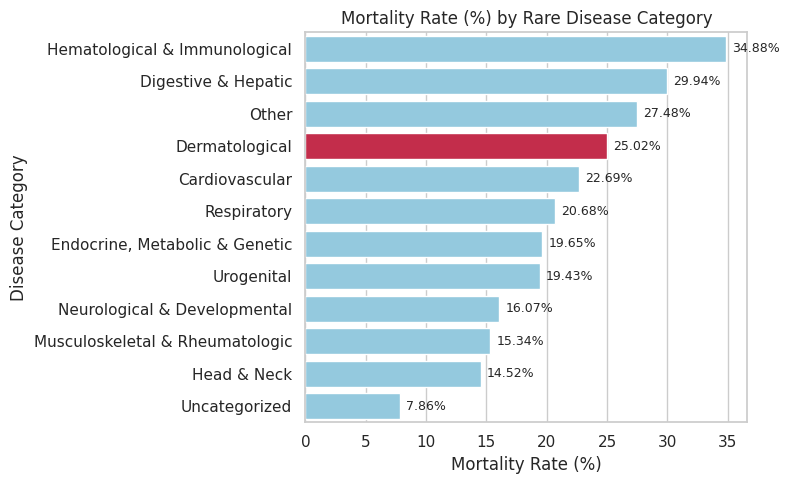

In [12]:
# Highlight dermatological category for later
highlight_category = "Dermatological"

# Set plot style
sns.set(style="whitegrid", palette="muted")

# Reorder dataframe by mortality rate
sorted_df = category_counts.sort_values('Mortality_Rate (%)', ascending=False)

# Define colors AFTER sorting
colors = ['crimson' if cat == highlight_category else 'skyblue' for cat in sorted_df['Simplified_Category']]

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=sorted_df, x='Mortality_Rate (%)', y='Simplified_Category', palette=colors)

# Add labels to bars
for i, value in enumerate(sorted_df['Mortality_Rate (%)']):
    ax.text(value + 0.5, i, f"{value:.2f}%", va='center', fontsize=9)

plt.title("Mortality Rate (%) by Rare Disease Category")
plt.xlabel("Mortality Rate (%)")
plt.ylabel("Disease Category")
plt.tight_layout()
plt.show()


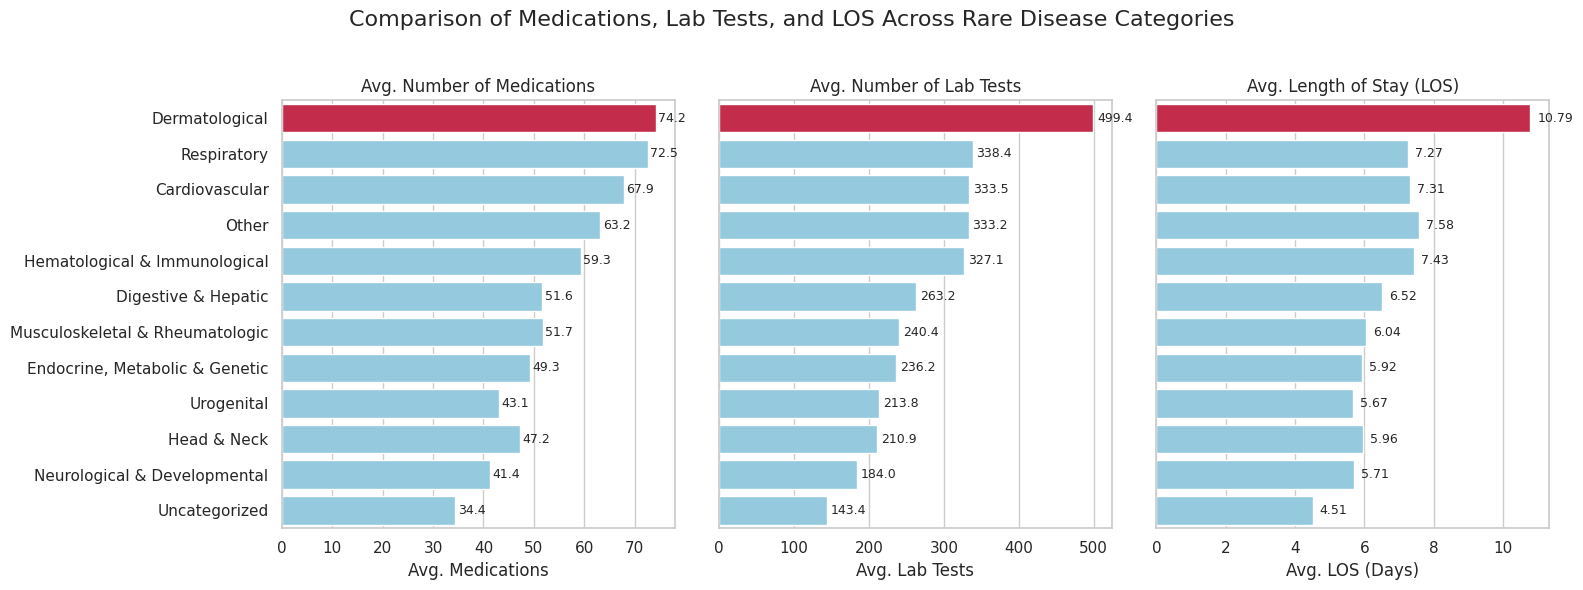

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort once based on a chosen metric (e.g., lab tests for consistent y-order across all subplots)
sort_metric = 'Avg_Num_Lab_Tests'
sorted_df = category_counts.sort_values(sort_metric, ascending=False)

# Prepare highlight colors
highlight_category = 'Dermatological'
colors = ['crimson' if cat == highlight_category else 'skyblue' for cat in sorted_df['Simplified_Category']]

# Setup subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True)

# Metric 1: Average Medications
sns.barplot(data=sorted_df, x='Avg_Num_Medications', y='Simplified_Category', palette=colors, ax=axes[0])
axes[0].set_title("Avg. Number of Medications")
axes[0].set_xlabel("Avg. Medications")
axes[0].set_ylabel("")
for i, value in enumerate(sorted_df['Avg_Num_Medications']):
    axes[0].text(value + 0.5, i, f"{value:.1f}", va='center', fontsize=9)

# Metric 2: Average Lab Tests
sns.barplot(data=sorted_df, x='Avg_Num_Lab_Tests', y='Simplified_Category', palette=colors, ax=axes[1])
axes[1].set_title("Avg. Number of Lab Tests")
axes[1].set_xlabel("Avg. Lab Tests")
axes[1].set_ylabel("")
for i, value in enumerate(sorted_df['Avg_Num_Lab_Tests']):
    axes[1].text(value + 5, i, f"{value:.1f}", va='center', fontsize=9)

# Metric 3: Average LOS
sns.barplot(data=sorted_df, x='Avg_LOS', y='Simplified_Category', palette=colors, ax=axes[2])
axes[2].set_title("Avg. Length of Stay (LOS)")
axes[2].set_xlabel("Avg. LOS (Days)")
axes[2].set_ylabel("")
for i, value in enumerate(sorted_df['Avg_LOS']):
    axes[2].text(value + 0.2, i, f"{value:.2f}", va='center', fontsize=9)

# Final layout adjustments
plt.suptitle("Comparison of Medications, Lab Tests, and LOS Across Rare Disease Categories", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


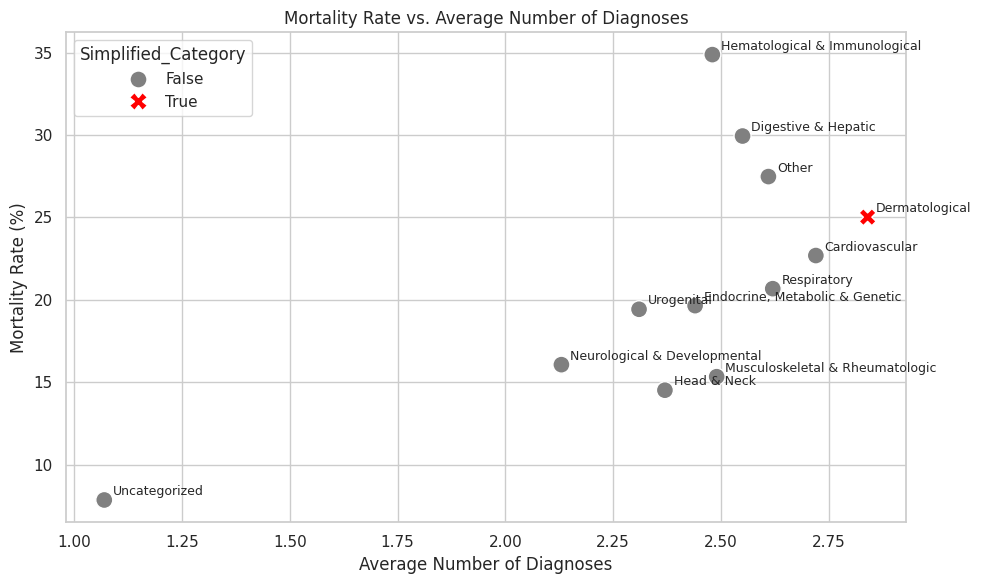

In [14]:
"Mortality Rate vs. Misdiagnoses"
plt.figure(figsize=(10, 6))
sns.scatterplot(data=category_counts,
                x='Avg_Num_Diagnoses',
                y='Mortality_Rate (%)',
                hue=(category_counts['Simplified_Category'] == highlight_category),
                style=(category_counts['Simplified_Category'] == highlight_category),
                palette={True: 'red', False: 'gray'},
                s=150)
for i, row in category_counts.iterrows():
    plt.text(row['Avg_Num_Diagnoses'] + 0.02, row['Mortality_Rate (%)'] + 0.3,
             row['Simplified_Category'], fontsize=9)
plt.title("Mortality Rate vs. Average Number of Diagnoses")
plt.xlabel("Average Number of Diagnoses")
plt.ylabel("Mortality Rate (%)")
plt.tight_layout()
plt.show()

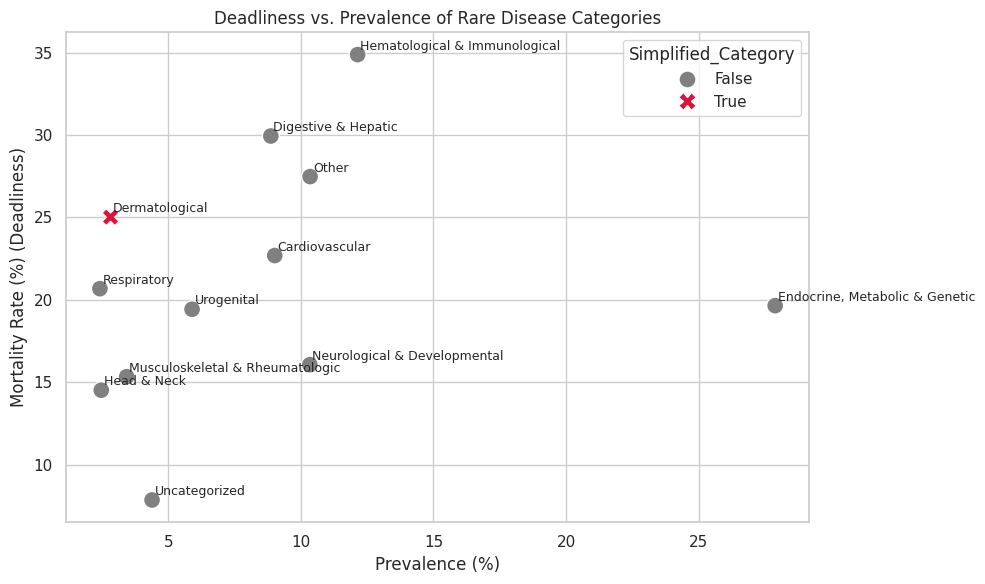

In [15]:
#Prevelance vs Deadliness - This shows it is rare enough but also deadly
#Compute Prevalence %
category_counts['Prevalence (%)'] = (
    category_counts['Unique_Patient_Count'] / category_counts['Unique_Patient_Count'].sum()
) * 100

# Step 2: Prepare scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=category_counts,
    x='Prevalence (%)',
    y='Mortality_Rate (%)',
    hue=(category_counts['Simplified_Category'] == highlight_category),
    style=(category_counts['Simplified_Category'] == highlight_category),
    palette={True: 'crimson', False: 'gray'},
    s=150
)

# Step 3: Add annotations
for i, row in category_counts.iterrows():
    plt.text(row['Prevalence (%)'] + 0.1, row['Mortality_Rate (%)'] + 0.3,
             row['Simplified_Category'], fontsize=9)

# Step 4: Labels and aesthetics
plt.title("Deadliness vs. Prevalence of Rare Disease Categories")
plt.xlabel("Prevalence (%)")
plt.ylabel("Mortality Rate (%) (Deadliness)")
plt.tight_layout()
plt.show()

Diseases in the top-left are deadly but rare. Diseases in the bottom-right are common but less deadly. Dermatological diseases' placement will visually show if they are rare but disproportionately deadly — your hypothesis!

In [16]:
#RARE SKIN DISEASES

# Step 1: Get unique subject-level clinical variables
clinical_info = df1[['subject_id', 'race', 'hospital_expire_flag', 'icd_code_list',
                    'los', 'num_prescriptions_drugs', 'total_lab_tests']].drop_duplicates()

# Step 2: Add number of diagnoses
clinical_info['num_diagnoses'] = clinical_info['icd_code_list'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

# Step 3: Filter for only rare skin disease patients
rare_skin = exploded[exploded['Simplified_Category'] == 'Dermatological']

# Step 4: Merge rare_skin with clinical_info
rare_skin_race = rare_skin.merge(clinical_info, on='subject_id', how='left')

# Step 5: Drop duplicate subject_id + race to avoid double counting
rare_skin_race = rare_skin_race.drop_duplicates(subset=['subject_id', 'race'])

# Step 6: Group by race and calculate metrics
race_grouped = (
    rare_skin_race
    .groupby('race')
    .agg(
        Unique_Patient_Count=('subject_id', 'nunique'),
        Death_Count=('hospital_expire_flag', 'sum'),
        Avg_Num_Diagnoses=('num_diagnoses', 'mean'),
        Avg_LOS=('los', 'mean'),
        Avg_Num_Medications=('num_prescriptions_drugs', 'mean'),
        Avg_Num_Lab_Tests=('total_lab_tests', 'mean')
    )
    .reset_index()
)

# Step 7: Mortality Rate
race_grouped['Mortality_Rate (%)'] = (
    100 * race_grouped['Death_Count'] / race_grouped['Unique_Patient_Count']
).round(2)

# Step 8: Round other columns
cols_to_round = ['Avg_Num_Diagnoses', 'Avg_LOS', 'Avg_Num_Medications', 'Avg_Num_Lab_Tests']
race_grouped[cols_to_round] = race_grouped[cols_to_round].round(2)

# Step 9: Map race labels
race_mapping = {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Latino', 5: 'Other', 6: 'Unknown'}
race_grouped['Race'] = race_grouped['race'].map(race_mapping)

# Step 10: Reorder columns
race_grouped = race_grouped[[
    'Race', 'Unique_Patient_Count', 'Death_Count', 'Mortality_Rate (%)',
    'Avg_Num_Diagnoses', 'Avg_LOS', 'Avg_Num_Medications', 'Avg_Num_Lab_Tests'
]]

print(race_grouped)


      Race  Unique_Patient_Count  Death_Count  Mortality_Rate (%)  Avg_Num_Diagnoses  Avg_LOS  Avg_Num_Medications  Avg_Num_Lab_Tests
0    White                   982           39               3.970              2.850   10.140               70.680            474.830
1    Black                   160            5               3.120              2.880    9.000               60.610            330.840
2    Asian                    61            1               1.640              2.590   12.680               67.520            622.000
3   Latino                    38            0               0.000              2.740   15.400               81.130            810.180
4    Other                    73            0               0.000              2.490    9.860               66.550            445.740
5  Unknown                   101           17              16.830              3.150   17.650              137.140            853.060


Latino and Asian patients tend to have longer hospital stays and higher intensity of care (medications, lab tests). This might suggest more complex cases, delayed diagnoses, or differences in clinical management for Latino and Asian patients. It might also be due to less data.


## 2. Basic EDA

Among the entire dataset what % of patients are common diseases and what % are rare diseases? Then in the rare diseases what % are males, females? Also give a divide between different races, marital_status and age groups? Among rare diseases, what % are rare skin diseases? What is the % of males and females in rare skin diseases, what is the % for different races, marital_status and age groups? Among common diseases, what % are common skin diseases, what is the % of males, females, races, marital_status and age groups?

In [17]:
# --- Define condition groups ---
df2['condition_group'] = df2['class'].apply(lambda x: 'Rare' if x in [1, 3, 5] else 'Common')
df2['rare_skin'] = df2['class'].apply(lambda x: 'Rare Skin' if x == 1 else ('Other Rare' if x in [3, 5] else None))

# Create age groups
bins = [0, 18, 35, 50, 65, 80, 200]
labels = ['0-17', '18-34', '35-49', '50-64', '65-79', '80+']
df2['age_group'] = pd.cut(df2['anchor_age'], bins=bins, labels=labels, right=False)

# --- Function to get % distribution ---
def percent_dist(df, col):
    return df[col].value_counts(normalize=True).sort_index() * 100

# --- Overall condition group percentages ---
cond_counts = df2['condition_group'].value_counts(normalize=True) * 100

# --- Rare diseases ---
rare_df = df2[df2['condition_group'] == 'Rare']
rare_gender_pct = percent_dist(rare_df, 'gender')
rare_race_pct = percent_dist(rare_df, 'race')
rare_marital_pct = percent_dist(rare_df, 'marital_status')
rare_age_pct = percent_dist(rare_df, 'age_group')

rare_skin_pct = (rare_df['rare_skin'] == 'Rare Skin').mean() * 100
rare_skin_df = rare_df[rare_df['rare_skin'] == 'Rare Skin']
rare_skin_gender_pct = percent_dist(rare_skin_df, 'gender')
rare_skin_race_pct = percent_dist(rare_skin_df, 'race')
rare_skin_marital_pct = percent_dist(rare_skin_df, 'marital_status')
rare_skin_age_pct = percent_dist(rare_skin_df, 'age_group')

# --- Common diseases ---
common_df = df2[df2['condition_group'] == 'Common']

# Common skin diseases (class == 2)
common_skin_df = df2[df2['class'] == 2]
common_skin_pct = (common_skin_df.shape[0] / common_df.shape[0]) * 100

common_skin_gender_pct = percent_dist(common_skin_df, 'gender')
common_skin_race_pct = percent_dist(common_skin_df, 'race')
common_skin_marital_pct = percent_dist(common_skin_df, 'marital_status')
common_skin_age_pct = percent_dist(common_skin_df, 'age_group')

# --- Print summaries (optional) ---
print(f"Overall condition distribution (%):\n{cond_counts}\n")
print(f"Rare skin diseases % of rare diseases: {rare_skin_pct:.2f}%")
print(f"Common skin diseases % of common diseases: {common_skin_pct:.2f}%")

Overall condition distribution (%):
condition_group
Common   55.015
Rare     44.985
Name: proportion, dtype: float64

Rare skin diseases % of rare diseases: 5.53%
Common skin diseases % of common diseases: 7.28%


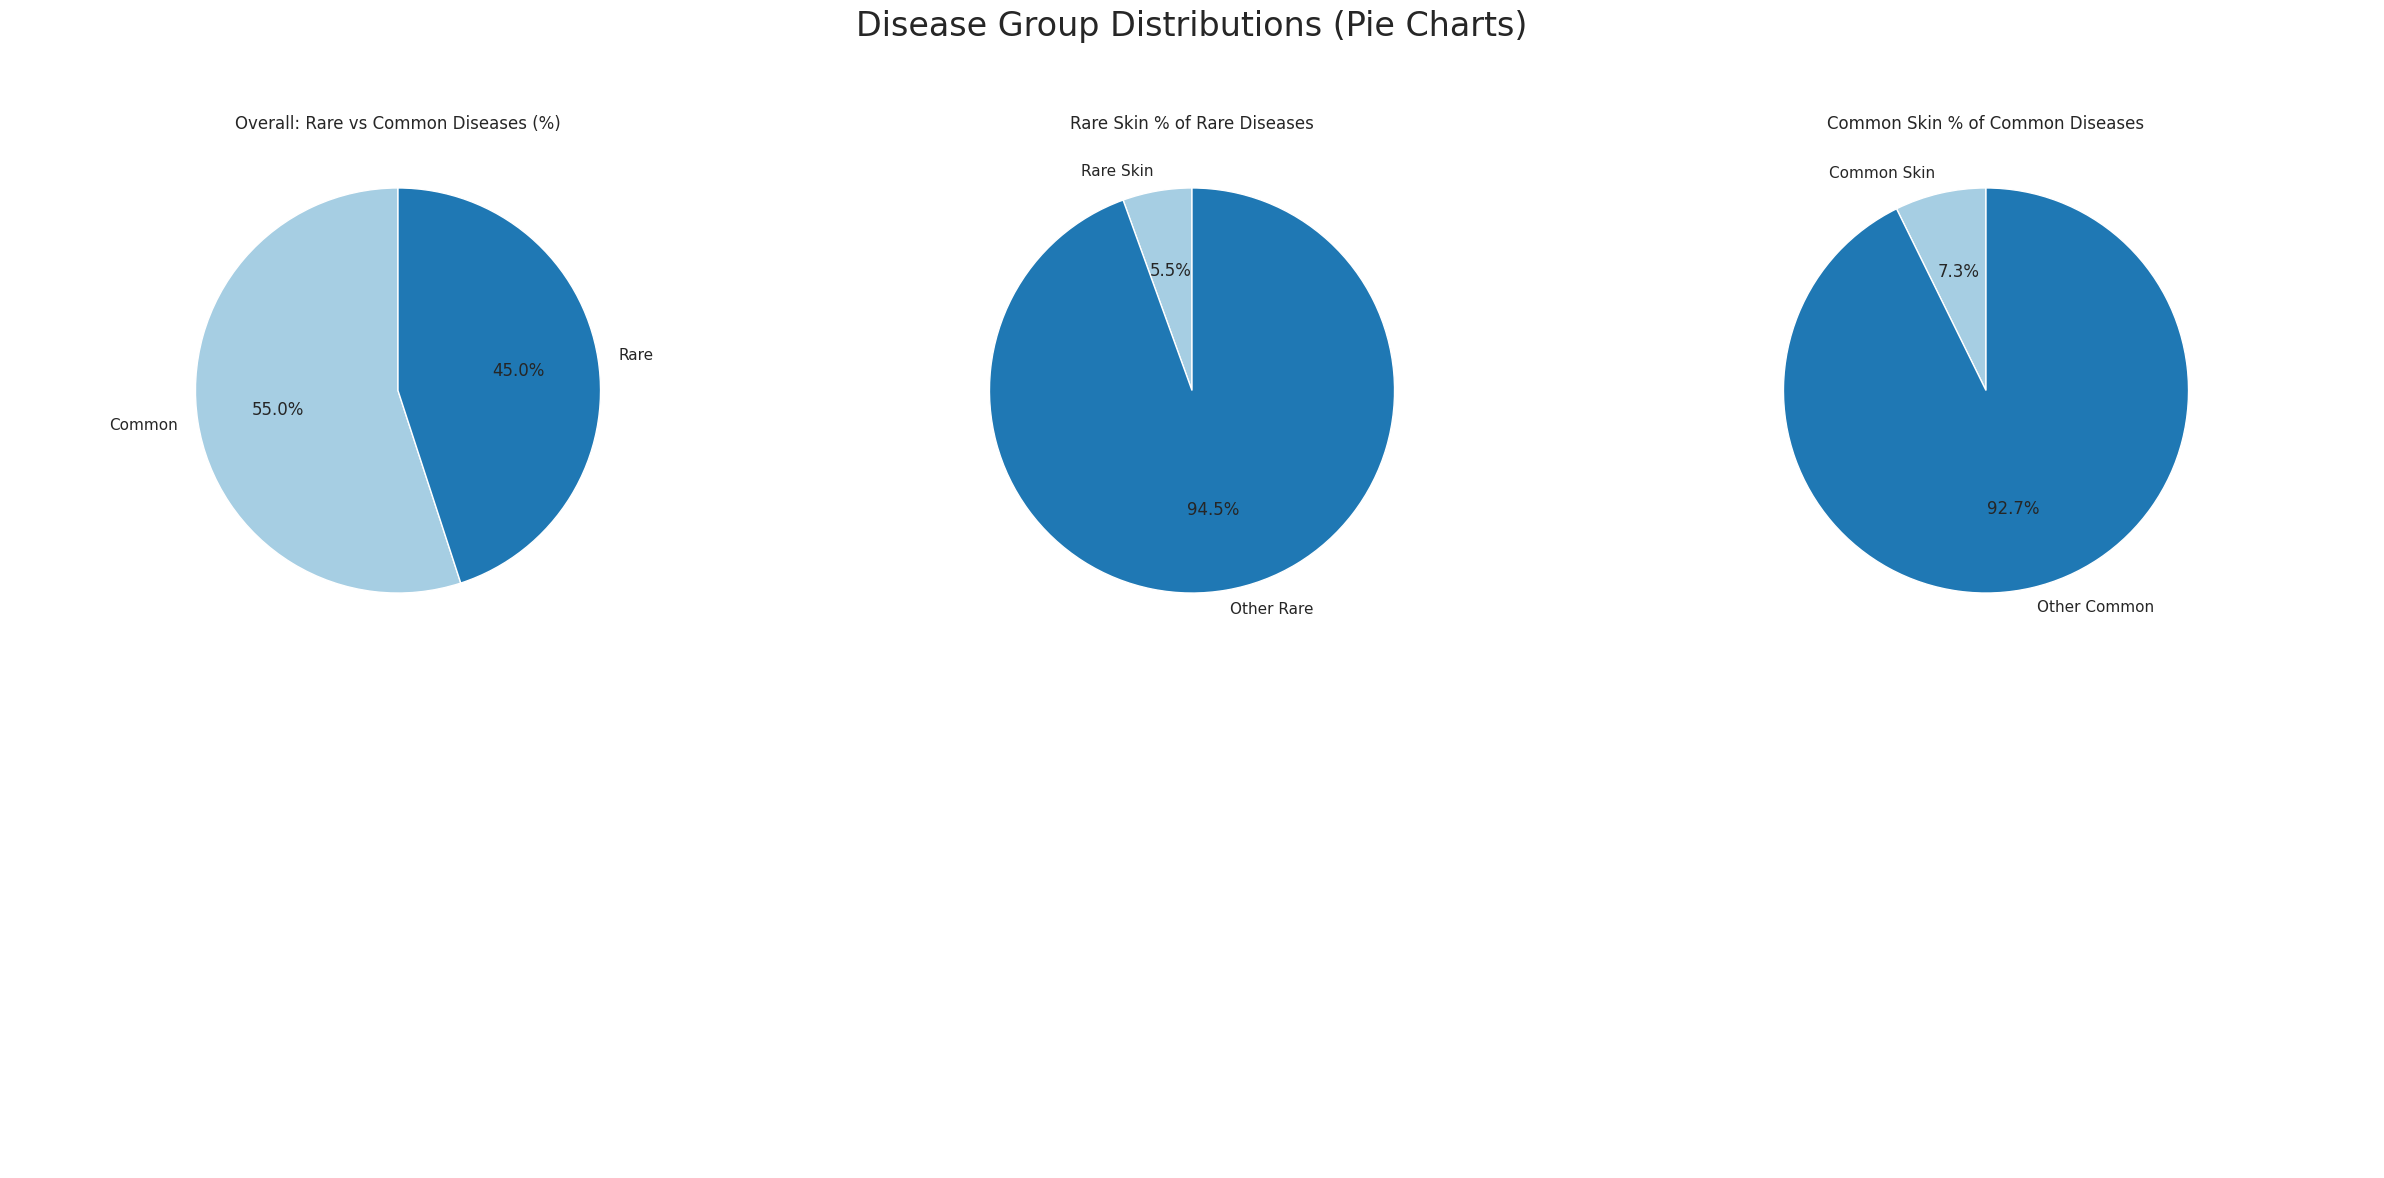

In [18]:
def plot_pie(data, title, ax):
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    ax.set_title(title)

fig, axs = plt.subplots(2, 3, figsize=(24, 12))
plt.suptitle("Disease Group Distributions (Pie Charts)", fontsize=24)

# axs is a 2D array: axs[row, col]

# 1. Overall condition distribution (Rare vs Common)
plot_pie(cond_counts, "Overall: Rare vs Common Diseases (%)", axs[0, 0])

# 2. Rare skin diseases % of rare diseases
rare_skin_pct_data = pd.Series([rare_skin_pct, 100 - rare_skin_pct], index=['Rare Skin', 'Other Rare'])
plot_pie(rare_skin_pct_data, "Rare Skin % of Rare Diseases", axs[0, 1])

# 3. Common skin diseases % of common diseases
common_skin_pct_data = pd.Series([common_skin_pct, 100 - common_skin_pct], index=['Common Skin', 'Other Common'])
plot_pie(common_skin_pct_data, "Common Skin % of Common Diseases", axs[0, 2])

# Leave axs[0,3] empty or use for legend/info
#axs[0, 3].axis('off')

# Optionally leave entire second row empty or use later
for i in range(3):
    axs[1, i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

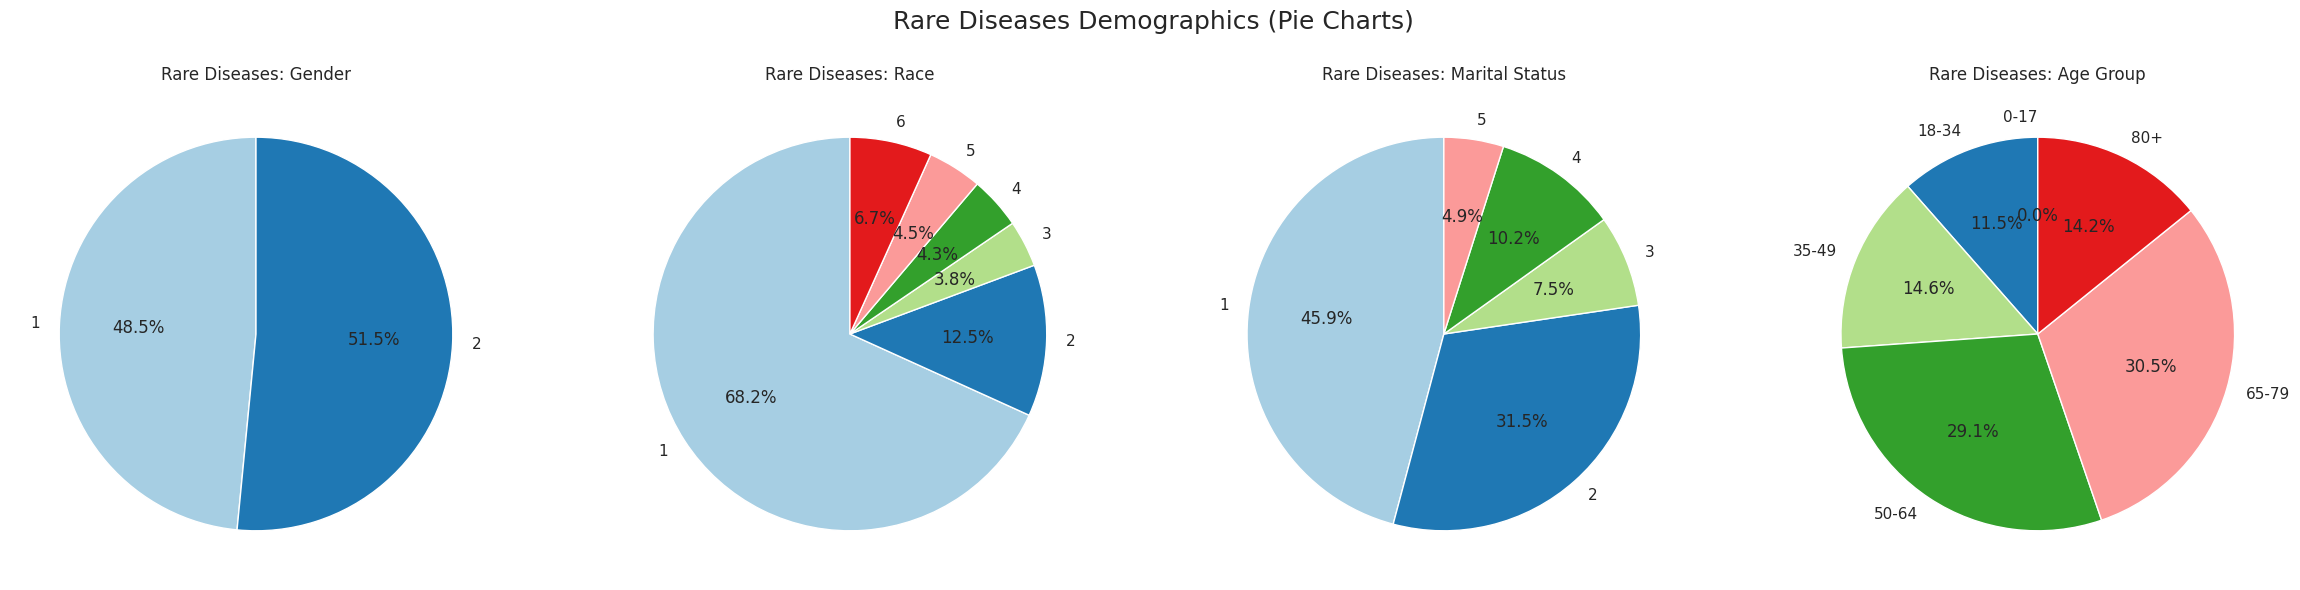

In [19]:
def plot_pie(data, title, ax):
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    ax.set_title(title)

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
plt.suptitle("Rare Diseases Demographics (Pie Charts)", fontsize=18)

plot_pie(rare_gender_pct, "Rare Diseases: Gender", axs[0])
plot_pie(rare_race_pct, "Rare Diseases: Race", axs[1])
plot_pie(rare_marital_pct, "Rare Diseases: Marital Status", axs[2])
plot_pie(rare_age_pct, "Rare Diseases: Age Group", axs[3])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


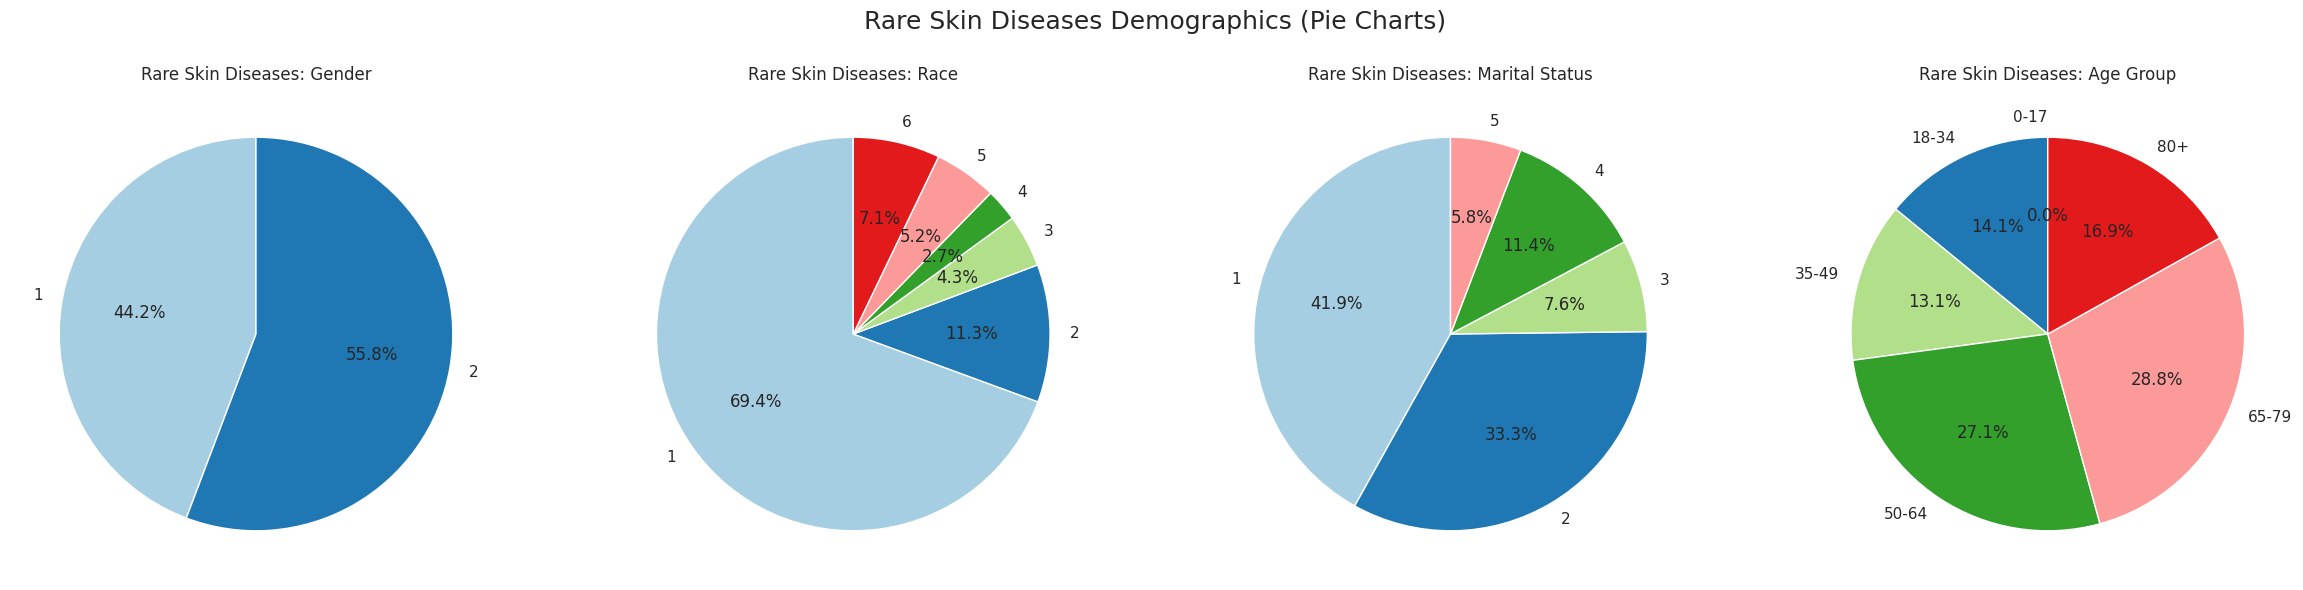

In [20]:
def plot_pie(data, title, ax):
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    ax.set_title(title)

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
plt.suptitle("Rare Skin Diseases Demographics (Pie Charts)", fontsize=18)

plot_pie(rare_skin_gender_pct, "Rare Skin Diseases: Gender", axs[0])
plot_pie(rare_skin_race_pct, "Rare Skin Diseases: Race", axs[1])
plot_pie(rare_skin_marital_pct, "Rare Skin Diseases: Marital Status", axs[2])
plot_pie(rare_skin_age_pct, "Rare Skin Diseases: Age Group", axs[3])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


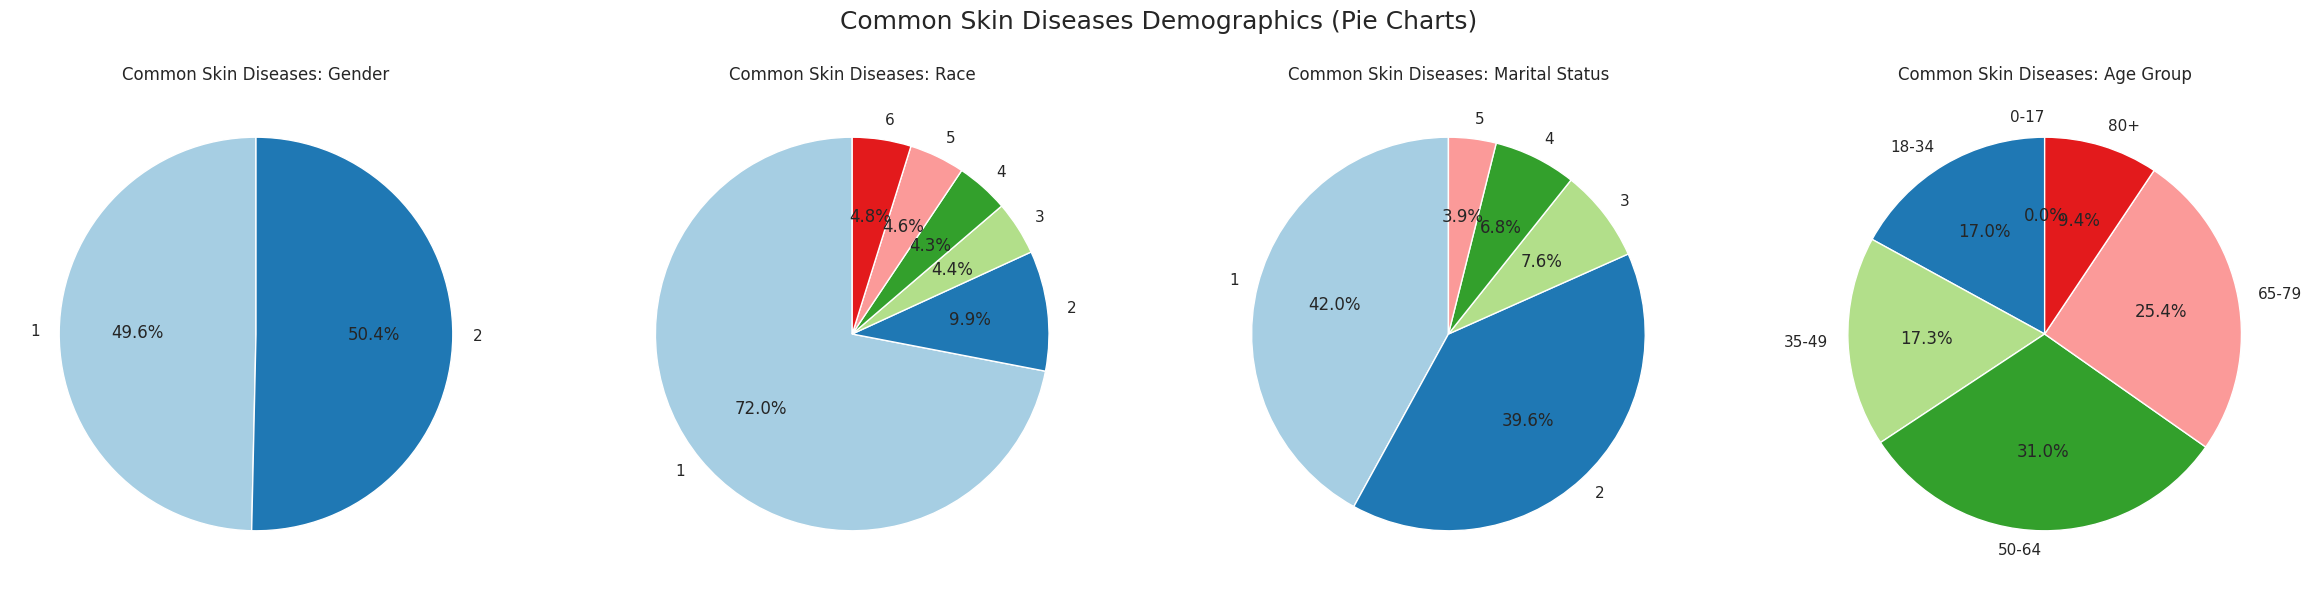

In [21]:
def plot_pie(data, title, ax):
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    ax.set_title(title)

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
plt.suptitle("Common Skin Diseases Demographics (Pie Charts)", fontsize=18)

plot_pie(common_skin_gender_pct, "Common Skin Diseases: Gender", axs[0])
plot_pie(common_skin_race_pct, "Common Skin Diseases: Race", axs[1])
plot_pie(common_skin_marital_pct, "Common Skin Diseases: Marital Status", axs[2])
plot_pie(common_skin_age_pct, "Common Skin Diseases: Age Group", axs[3])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Do some write up between common skin and rare skin conditions based on the charts.

Can we find out the most common sub groups in rare skin diseases vs common skin diseases? Excluding race because most common are whites. Generating the counts separately for Blacks, Asians and Latinos

In [22]:
# 1. Map numeric codes to labels
gender_map = {1: 'Male', 2: 'Female'}
#race_map = {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Latino', 5: 'Other', 6: 'Unknown'}
marital_map = {1: 'Married', 2: 'Single', 3: 'Divorced', 4: 'Widowed', 5: 'Unknown'}

# Assuming df2 columns are coded as numeric, map them:
df2['gender_label'] = df2['gender'].map(gender_map)
#df2['race_label'] = df2['race'].map(race_map)
df2['marital_label'] = df2['marital_status'].map(marital_map)

# Age groups already categorical strings like '18-34', '35-49', etc.
# Make sure age_group is string type
df2['age_group'] = df2['age_group'].astype(str)

# 2. Create subgroup string
#df2['subgroup'] = (df2['race_label'] + " | " + df2['gender_label'] + " | " + df2['age_group'] + " | " + df2['marital_label'])
df2['subgroup'] = (df2['gender_label'] + " | " + df2['age_group'] + " | " + df2['marital_label'])

# 3. Filter rare skin diseases and common skin diseases
rare_skin_df = df2[df2['class'] == 1]
common_skin_df = df2[df2['class'] == 2]

# 4. Count subgroups
rare_skin_counts = rare_skin_df['subgroup'].value_counts().reset_index()
rare_skin_counts.columns = ['Subgroup', 'Count']

common_skin_counts = common_skin_df['subgroup'].value_counts().reset_index()
common_skin_counts.columns = ['Subgroup', 'Count']

# 5. Show top 10 subgroups for each
print("Top 10 Subgroups in Rare Skin Diseases:")
print(rare_skin_counts.head(10))

print("\nTop 10 Subgroups in Common Skin Diseases:")
print(common_skin_counts.head(10))

Top 10 Subgroups in Rare Skin Diseases:
                   Subgroup  Count
0    Male | 65-79 | Married    123
1   Female | 18-34 | Single    106
2  Female | 65-79 | Married     94
3    Male | 50-64 | Married     94
4  Female | 50-64 | Married     85
5      Male | 80+ | Married     72
6   Female | 50-64 | Single     66
7    Female | 80+ | Widowed     65
8     Male | 50-64 | Single     64
9     Male | 18-34 | Single     52

Top 10 Subgroups in Common Skin Diseases:
                   Subgroup  Count
0    Male | 65-79 | Married    204
1    Male | 50-64 | Married    184
2   Female | 18-34 | Single    178
3     Male | 50-64 | Single    140
4  Female | 50-64 | Married    136
5   Female | 50-64 | Single    132
6     Male | 18-34 | Single    114
7  Female | 65-79 | Married    111
8   Female | 35-49 | Single     99
9     Male | 35-49 | Single     97


In [23]:
# Define race codes (adjust if needed)
race_codes = {
    'Black': 2,
    'Asian': 3,
    'Latino': 4,
}

for race_name, race_code in race_codes.items():
    print(f"\nTop 10 Subgroups for {race_name} Patients (Rare Skin Diseases):")
    rare_skin_race_df = rare_skin_df[rare_skin_df['race'] == race_code]
    rare_skin_race_counts = rare_skin_race_df['subgroup'].value_counts().reset_index()
    rare_skin_race_counts.columns = ['Subgroup', 'Count']
    print(rare_skin_race_counts.head(10))

    print(f"\nTop 10 Subgroups for {race_name} Patients (Common Skin Diseases):")
    common_skin_race_df = common_skin_df[common_skin_df['race'] == race_code]
    common_skin_race_counts = common_skin_race_df['subgroup'].value_counts().reset_index()
    common_skin_race_counts.columns = ['Subgroup', 'Count']
    print(common_skin_race_counts.head(10))


Top 10 Subgroups for Black Patients (Rare Skin Diseases):
                   Subgroup  Count
0   Female | 18-34 | Single     15
1   Female | 50-64 | Single     14
2    Male | 65-79 | Married     11
3   Female | 35-49 | Single     11
4    Male | 50-64 | Married     11
5   Female | 65-79 | Single     10
6  Female | 50-64 | Married      9
7    Female | 80+ | Widowed      8
8      Male | 80+ | Married      6
9     Male | 50-64 | Single      6

Top 10 Subgroups for Black Patients (Common Skin Diseases):
                   Subgroup  Count
0   Female | 18-34 | Single     32
1   Female | 35-49 | Single     30
2   Female | 50-64 | Single     24
3     Male | 18-34 | Single     18
4     Male | 50-64 | Single     14
5   Female | 65-79 | Single     13
6  Female | 35-49 | Married     13
7     Male | 35-49 | Single     10
8    Male | 50-64 | Married      9
9    Male | 35-49 | Married      8

Top 10 Subgroups for Asian Patients (Rare Skin Diseases):
                   Subgroup  Count
0     Male | 18-

## 3. Are rare skin diseases becoming rare or commmon over time?

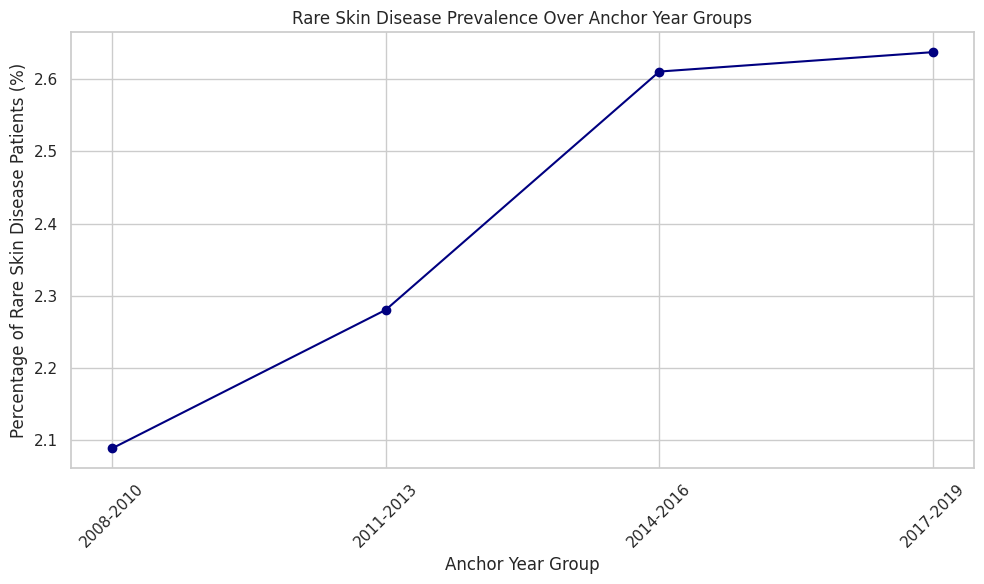

In [24]:
# 1. Combine start and end year into a string group
df3['anchor_year_group'] = df3['anchor_year_start'].astype(str) + '-' + df3['anchor_year_end'].astype(str)

# 2. Filter out rows with missing anchor_year_group (if any)
df3_filtered = df3[df3['anchor_year_group'].notnull()]

# 3. Create flag for rare skin disease
df3_filtered['is_rare_skin'] = df3_filtered['class'] == 1

# 4. Group by anchor_year_group and calculate prevalence
grouped = df3_filtered.groupby('anchor_year_group').agg(
    total_patients=('subject_id', 'count'),
    rare_skin_patients=('is_rare_skin', 'sum')
).reset_index()

grouped['rare_skin_percent'] = 100 * grouped['rare_skin_patients'] / grouped['total_patients']

# 5. Sort groups by start year to plot chronologically
grouped['start_year'] = grouped['anchor_year_group'].str.split('-').str[0].astype(int)
grouped = grouped.sort_values('start_year')

# 6. Plot
plt.figure(figsize=(10, 6))
plt.plot(grouped['anchor_year_group'], grouped['rare_skin_percent'], marker='o', color='navy')
plt.title('Rare Skin Disease Prevalence Over Anchor Year Groups')
plt.xlabel('Anchor Year Group')
plt.ylabel('Percentage of Rare Skin Disease Patients (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


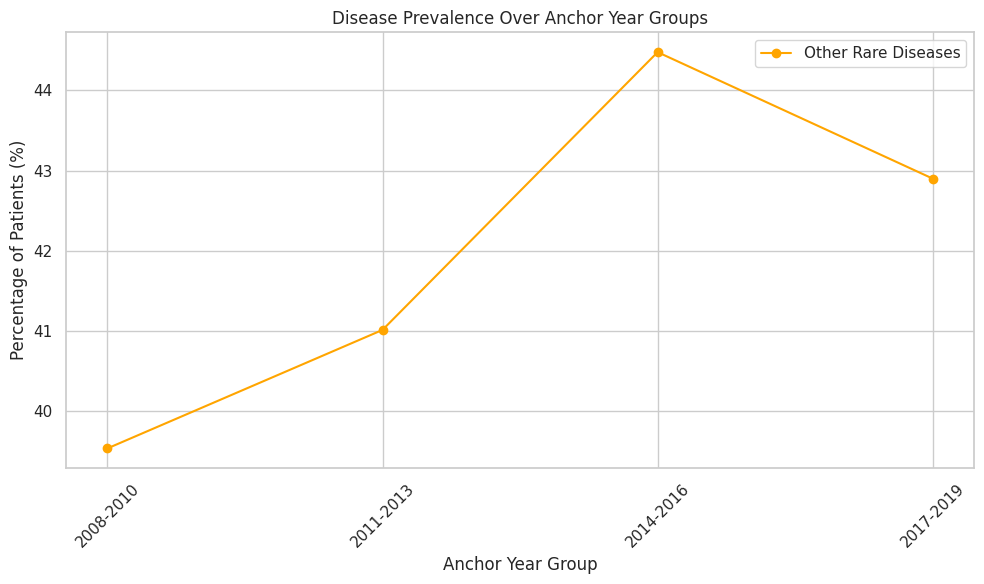

In [25]:
# 1. Combine start and end year into a string group (if not already done)
df3['anchor_year_group'] = df3['anchor_year_start'].astype(str) + '-' + df3['anchor_year_end'].astype(str)

# 2. Filter out rows with missing anchor_year_group (if any)
df3_filtered = df3[df3['anchor_year_group'].notnull()]

# 3. Create flags for each group
df3_filtered['is_other_rare'] = df3_filtered['class'].isin([3, 5])

# 4. Group by anchor_year_group and calculate counts and prevalences
grouped = df3_filtered.groupby('anchor_year_group').agg(
    total_patients=('subject_id', 'count'),
    other_rare_patients=('is_other_rare', 'sum')
).reset_index()

# Calculate percentages
grouped['other_rare_percent'] = 100 * grouped['other_rare_patients'] / grouped['total_patients']

# 5. Sort groups by start year to plot chronologically
grouped['start_year'] = grouped['anchor_year_group'].str.split('-').str[0].astype(int)
grouped = grouped.sort_values('start_year')

# 6. Plot all three lines
plt.figure(figsize=(10, 6))
plt.plot(grouped['anchor_year_group'], grouped['other_rare_percent'], marker='o', label='Other Rare Diseases', color='orange')

plt.title('Disease Prevalence Over Anchor Year Groups')
plt.xlabel('Anchor Year Group')
plt.ylabel('Percentage of Patients (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


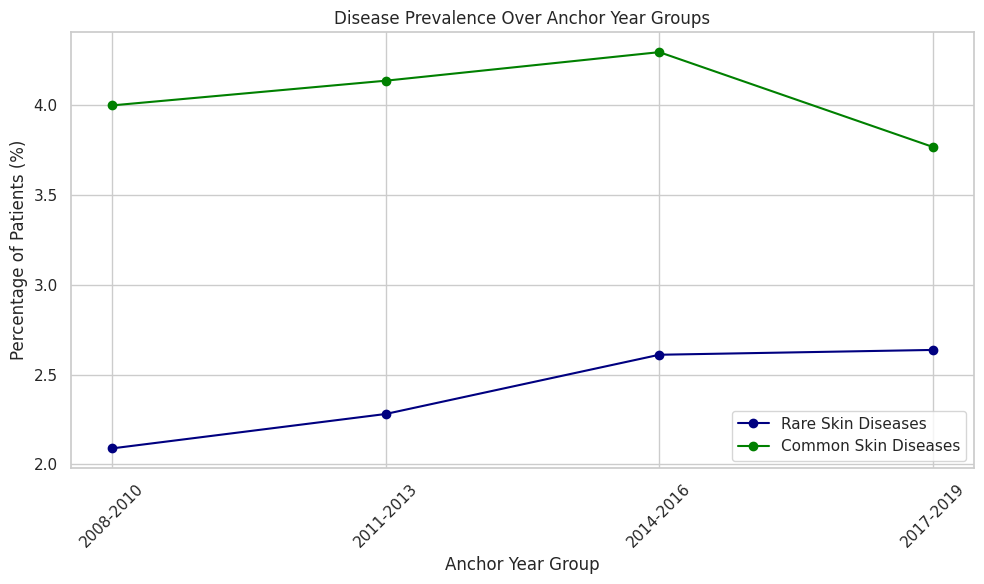

In [26]:
# 1. Combine start and end year into a string group (if not already done)
df3['anchor_year_group'] = df3['anchor_year_start'].astype(str) + '-' + df3['anchor_year_end'].astype(str)

# 2. Filter out rows with missing anchor_year_group (if any)
df3_filtered = df3[df3['anchor_year_group'].notnull()]

# 3. Create flags for each group
df3_filtered['is_rare_skin'] = df3_filtered['class'] == 1
df3_filtered['is_common_skin'] = df3_filtered['class'] == 2

# 4. Group by anchor_year_group and calculate counts and prevalences
grouped = df3_filtered.groupby('anchor_year_group').agg(
    total_patients=('subject_id', 'count'),
    rare_skin_patients=('is_rare_skin', 'sum'),
    common_skin_patients=('is_common_skin', 'sum')
).reset_index()

# Calculate percentages
grouped['rare_skin_percent'] = 100 * grouped['rare_skin_patients'] / grouped['total_patients']
grouped['common_skin_percent'] = 100 * grouped['common_skin_patients'] / grouped['total_patients']

# 5. Sort groups by start year to plot chronologically
grouped['start_year'] = grouped['anchor_year_group'].str.split('-').str[0].astype(int)
grouped = grouped.sort_values('start_year')

# 6. Plot all three lines
plt.figure(figsize=(10, 6))
plt.plot(grouped['anchor_year_group'], grouped['rare_skin_percent'], marker='o', label='Rare Skin Diseases', color='navy')
plt.plot(grouped['anchor_year_group'], grouped['common_skin_percent'], marker='o', label='Common Skin Diseases', color='green')

plt.title('Disease Prevalence Over Anchor Year Groups')
plt.xlabel('Anchor Year Group')
plt.ylabel('Percentage of Patients (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

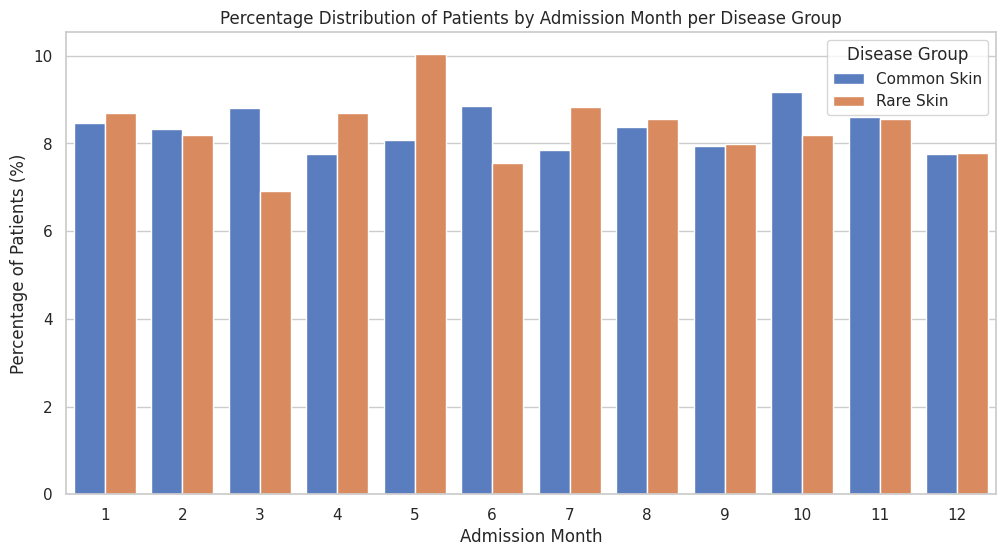

In [27]:
# Map classes to groups
def assign_group(x):
    if x == 1:
        return 'Rare Skin'
    elif x == 2:
        return 'Common Skin'

df3['disease_group'] = df3['class'].apply(assign_group)

# Filter to valid admit_month values
df3 = df3[df3['admit_month'].notnull()]

# Calculate percentage distribution of patients over months within each disease group
grouped = (
    df3.groupby(['disease_group', 'admit_month'])
    .size()
    .reset_index(name='count')
)

# Calculate total patients per disease group for percentage
total_per_group = grouped.groupby('disease_group')['count'].transform('sum')
grouped['percent'] = 100 * grouped['count'] / total_per_group

# Plot grouped barplot: x=admit_month, y=percent, hue=disease_group
plt.figure(figsize=(12,6))
sns.barplot(data=grouped, x='admit_month', y='percent', hue='disease_group')

plt.title('Percentage Distribution of Patients by Admission Month per Disease Group')
plt.xlabel('Admission Month')
plt.ylabel('Percentage of Patients (%)')
plt.legend(title='Disease Group')
plt.show()

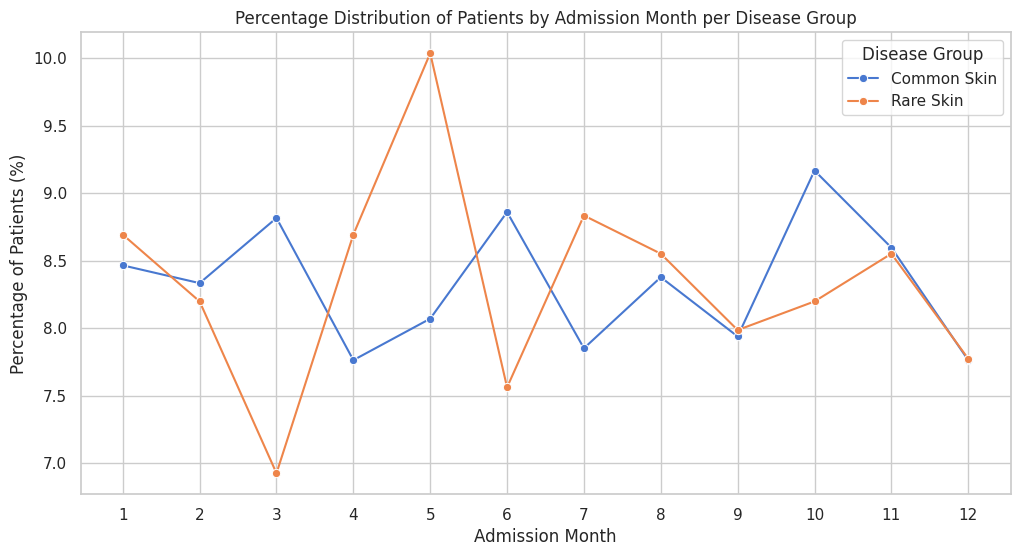

In [28]:
# Map classes to groups
def assign_group(x):
    if x == 1:
        return 'Rare Skin'
    elif x == 2:
        return 'Common Skin'

df3['disease_group'] = df3['class'].apply(assign_group)

# Filter to valid admit_month values
df3 = df3[df3['admit_month'].notnull()]

# Calculate percentage distribution of patients over months within each disease group
grouped = (
    df3.groupby(['disease_group', 'admit_month'])
    .size()
    .reset_index(name='count')
)

# Calculate total patients per disease group for percentage
total_per_group = grouped.groupby('disease_group')['count'].transform('sum')
grouped['percent'] = 100 * grouped['count'] / total_per_group

# Plot line plot: x=admit_month, y=percent, hue=disease_group
plt.figure(figsize=(12,6))

sns.lineplot(data=grouped, x='admit_month', y='percent', hue='disease_group', marker='o')

plt.title('Percentage Distribution of Patients by Admission Month per Disease Group')
plt.xlabel('Admission Month')
plt.ylabel('Percentage of Patients (%)')
plt.xticks(range(1,13))  # Assuming admit_month is 1-12
plt.legend(title='Disease Group')
plt.grid(True)
plt.show()

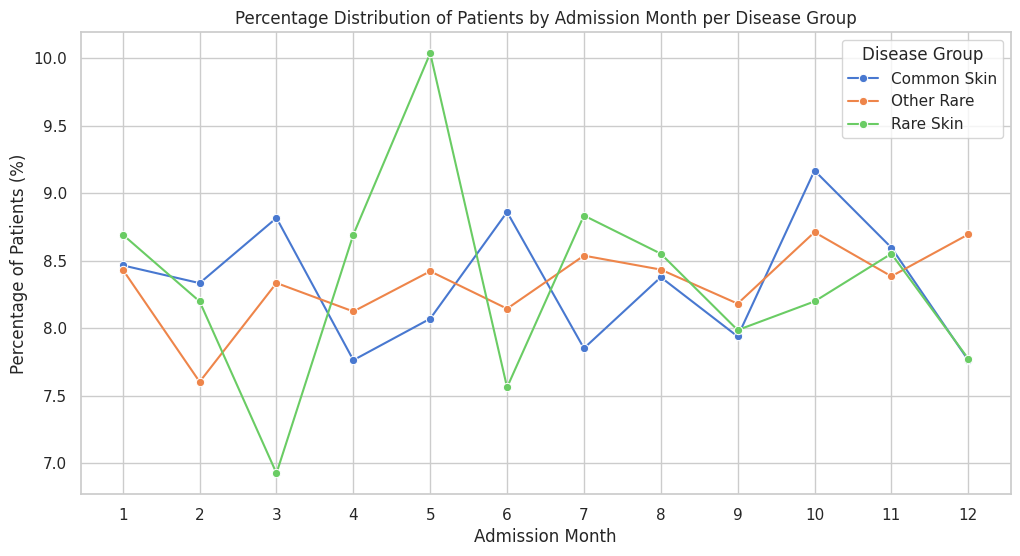

In [29]:
# Map classes to groups
def assign_group(x):
    if x == 1:
        return 'Rare Skin'
    elif x == 2:
        return 'Common Skin'
    elif x in [3, 5]:
        return 'Other Rare'

df3['disease_group'] = df3['class'].apply(assign_group)

# Filter to valid admit_month values
df3 = df3[df3['admit_month'].notnull()]

# Calculate percentage distribution of patients over months within each disease group
grouped = (
    df3.groupby(['disease_group', 'admit_month'])
    .size()
    .reset_index(name='count')
)

# Calculate total patients per disease group for percentage
total_per_group = grouped.groupby('disease_group')['count'].transform('sum')
grouped['percent'] = 100 * grouped['count'] / total_per_group

# Plot line plot: x=admit_month, y=percent, hue=disease_group
plt.figure(figsize=(12,6))

sns.lineplot(data=grouped, x='admit_month', y='percent', hue='disease_group', marker='o')

plt.title('Percentage Distribution of Patients by Admission Month per Disease Group')
plt.xlabel('Admission Month')
plt.ylabel('Percentage of Patients (%)')
plt.xticks(range(1,13))  # Assuming admit_month is 1-12
plt.legend(title='Disease Group')
plt.grid(True)
plt.show()

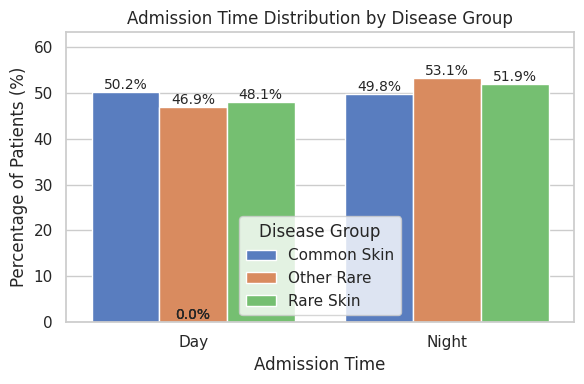

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map classes to groups
def assign_group(x):
    if x == 1:
        return 'Rare Skin'
    elif x == 2:
        return 'Common Skin'
    elif x in [3, 5]:
        return 'Other Rare'

df3['disease_group'] = df3['class'].apply(assign_group)

# Replace 0/1 with labels for clarity
df3 = df3[df3['is_night_admit'].notnull()]
df3['admit_time'] = df3['is_night_admit'].map({0: 'Day', 1: 'Night'})

# Group and calculate percentages
grouped = (
    df3.groupby(['disease_group', 'admit_time'])
    .size()
    .reset_index(name='count')
)

total_per_group = grouped.groupby('disease_group')['count'].transform('sum')
grouped['percent'] = 100 * grouped['count'] / total_per_group

# Plot grouped barplot with percentage labels
plt.figure(figsize=(6,4))
ax = sns.barplot(data=grouped, x='admit_time', y='percent', hue='disease_group')

plt.title('Admission Time Distribution by Disease Group')
plt.xlabel('Admission Time')
plt.ylabel('Percentage of Patients (%)')
plt.legend(title='Disease Group')

# Annotate bars with percentage values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(grouped['percent']) + 10)  # add some space above bars
plt.tight_layout()
plt.show()


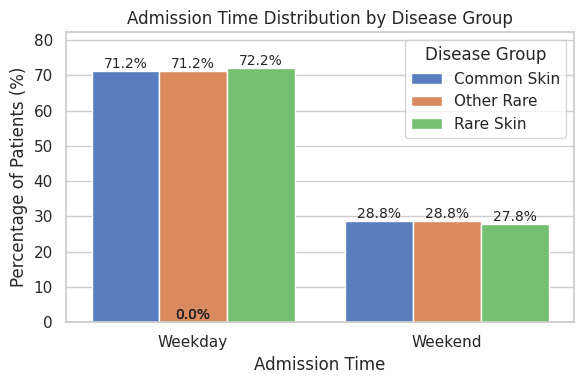

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map classes to groups
def assign_group(x):
    if x == 1:
        return 'Rare Skin'
    elif x == 2:
        return 'Common Skin'
    elif x in [3, 5]:
        return 'Other Rare'

df3['disease_group'] = df3['class'].apply(assign_group)

# Replace 0/1 with labels for clarity
df3 = df3[df3['is_weekend_admit'].notnull()]
df3['admit_time'] = df3['is_weekend_admit'].map({0: 'Weekday', 1: 'Weekend'})

# Group and calculate percentages
grouped = (
    df3.groupby(['disease_group', 'admit_time'])
    .size()
    .reset_index(name='count')
)

total_per_group = grouped.groupby('disease_group')['count'].transform('sum')
grouped['percent'] = 100 * grouped['count'] / total_per_group

# Plot grouped barplot with percentage labels
plt.figure(figsize=(6,4))
ax = sns.barplot(data=grouped, x='admit_time', y='percent', hue='disease_group')

plt.title('Admission Time Distribution by Disease Group')
plt.xlabel('Admission Time')
plt.ylabel('Percentage of Patients (%)')
plt.legend(title='Disease Group')

# Annotate bars with percentage values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(grouped['percent']) + 10)  # add some space above bars
plt.tight_layout()
plt.show()


## 4. Co-morbidity profiling of rare skin diseases

In [32]:
# Filter for class == 1
rare_skin_icd = df4[df4['class'] == 1][['class', 'icd_code', 'long_title']]

# Count occurrences of each icd_code within class 1
icd_counts = rare_skin_icd['icd_code'].value_counts().reset_index()
icd_counts.columns = ['icd_code', 'count']

# Merge counts back with the filtered dataframe (to get long_title)
# Drop duplicates to get one row per icd_code with long_title and count
merged_df = rare_skin_icd.drop_duplicates(subset=['icd_code']).merge(icd_counts, on='icd_code')

# Sort by count descending
merged_df = merged_df.sort_values(by='count', ascending=False).reset_index(drop=True)

merged_df

class icd_code                                         long_title  count
0       1     L270  Generalized skin eruption due to drugs and med...    368
1       1     E854                          Organ-limited amyloidosis    228
2       1     B372                       Candidiasis of skin and nail     79
3       1     Q796                            Ehlers-Danlos syndromes     66
4       1     M349                    Systemic sclerosis, unspecified     49
5       1     L930                        Discoid lupus erythematosus     44
6       1     L120                                 Bullous pemphigoid     40
7       1     G901                  Familial dysautonomia [Riley-Day]     39
8       1     L988  Other specified disorders of the skin and subc...     38
9       1     L308                         Other specified dermatitis     31
10      1     M722                       Plantar fascial fibromatosis     29
11      1      L88                               Pyoderma gangrenosum     28
12      1     C439            Malignant melanoma of skin, unspecified     28
13      1     M341                                   CR(E)ST syndrome     28
14      1     L982            Febrile neutrophilic dermatosis [Sweet]     17
15      1     M352                                   Behcet's disease     14
16      1     D692                  Other nonthrombocytopenic purpura     14
17      1     L918           Other hypertrophic disorders of the skin     12
18      1     K130                                   Diseases of lips     12
19      1     D179            Benign lipomatous neoplasm, unspecified     11
20      1     I780              Hereditary hemorrhagic telangiectasia     11
21      1     C434               Malignant melanoma of scalp and neck     10
22      1     L598  Other specified disorders of the skin and subc...     10
23      1     L738               Other specified follicular disorders     10
24      1     C109      Malignant neoplasm of oropharynx, unspecified      9
25      1     E882              Lipomatosis, not elsewhere classified      9
26      1     D225                          Melanocytic nevi of trunk      8
27      1     E881            Lipodystrophy, not elsewhere classified      8
28      1     M358  Other specified systemic involvement of connec...      7
29      1     Q851                                 Tuberous sclerosis      6
30      1     L218                        Other seborrheic dermatitis      6
31      1     L100                                 Pemphigus vulgaris      6
32      1     E801                            Porphyria cutanea tarda      6
33      1     Q828   Other specified congenital malformations of skin      5
34      1     L603                                     Nail dystrophy      5
35      1     L658              Other specified nonscarring hair loss      5
36      1     L401                     Generalized pustular psoriasis      5
37      1     D235             Other benign neoplasm of skin of trunk      5
38      1     L817                      Pigmented purpuric dermatosis      4
39      1      D71  Functional disorders of polymorphonuclear neut...      4
40      1     L568  Other specified acute skin changes due to ultr...      4
41      1     L814                    Other melanin hyperpigmentation      4
42      1     Q820                              Hereditary lymphedema      4
43      1     L940                    Localized scleroderma [morphea]      4
44      1     L502                     Urticaria due to cold and heat      4
45      1     L858               Other specified epidermal thickening      4
46      1     D229                      Melanocytic nevi, unspecified      4
47      1     L608                               Other nail disorders      3
48      1     Q781                      Polyostotic fibrous dysplasia      3
49      1     L985                              Mucinosis of the skin      3
50      1     M340                     Progressive systemic sclerosis      3


In [33]:
import pandas as pd
from collections import Counter

# 1. Filter rare skin disease admissions
rare_skin_df = df4[df4['class'] == 1]

# 2. Convert icd_code_list from string to list (adjust delimiter if needed)
rare_skin_df['icd_code_list'] = rare_skin_df['icd_code_list'].apply(lambda x: x.split(','))

# 3. Remove the primary diagnosis code if it appears in the list (assuming primary code in 'icd_code')
def remove_primary(icd_list, primary_code):
    return [code.strip() for code in icd_list if code.strip() != primary_code.strip()]

rare_skin_df['comorbid_codes'] = rare_skin_df.apply(
    lambda row: remove_primary(row['icd_code_list'], row['icd_code']), axis=1
)

# 4. Flatten list of all comorbid codes
all_comorbid_codes = [code for sublist in rare_skin_df['comorbid_codes'] for code in sublist]

# 5. Count frequencies
comorbid_counts = Counter(all_comorbid_codes)

# 6. Convert to DataFrame and sort descending
comorbid_df = pd.DataFrame(comorbid_counts.items(), columns=['icd_code', 'count'])
comorbid_df = comorbid_df.sort_values('count', ascending=False).reset_index(drop=True)

# First, drop duplicates in df4 to ensure clean join
df4_unique = df4[['icd_code', 'long_title']].drop_duplicates()
# Inner join on icd_code
merged_df1 = pd.merge(comorbid_df, df4_unique, on='icd_code', how='inner')
# Optional: sort by count descending
merged_df1 = merged_df1.sort_values(by='count', ascending=False)
# Display the result
print(merged_df1[['icd_code', 'long_title', 'count']])

    icd_code                                         long_title  count
0        I10                   Essential (primary) hypertension    492
1       N179                  Acute kidney failure, unspecified    256
2       E119     Type 2 diabetes mellitus without complications    127
3       J449  Chronic obstructive pulmonary disease, unspeci...    100
4       A419                       Sepsis, unspecified organism     84
5       J189                    Pneumonia, unspecified organism     81
6       D509                Iron deficiency anemia, unspecified     65
7      I5033  Acute on chronic diastolic (congestive) heart ...     50
8       I272             Other secondary pulmonary hypertension     40
9       D684             Acquired coagulation factor deficiency     36
11     I5032       Chronic diastolic (congestive) heart failure     34
10     I5023  Acute on chronic systolic (congestive) heart f...     34
12      I951                            Orthostatic hypotension     34
13    

/tmp/ipython-input-33-365569438.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rare_skin_df['icd_code_list'] = rare_skin_df['icd_code_list'].apply(lambda x: x.split(','))
/tmp/ipython-input-33-365569438.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rare_skin_df['comorbid_codes'] = rare_skin_df.apply(


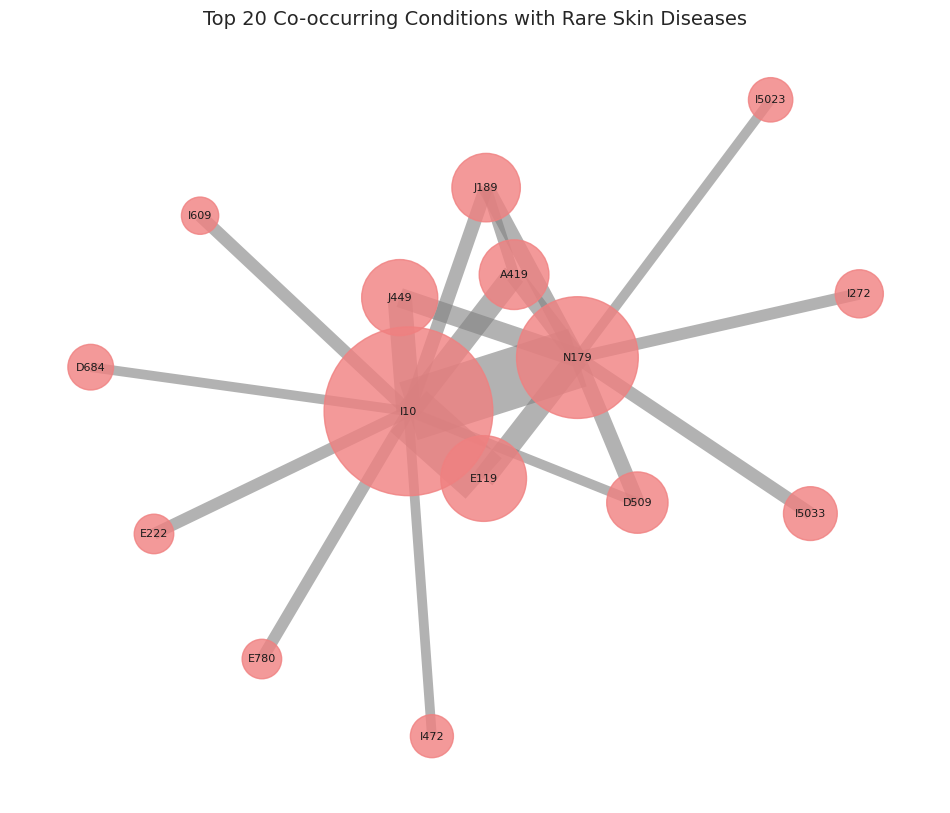

In [34]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

# 1. Filter rare skin disease patients
rare_skin_df = df4[df4['class'] == 1].copy()

# 2. Parse icd_code_list into lists
rare_skin_df['icd_codes'] = rare_skin_df['icd_code_list'].apply(lambda x: x.split(','))

# 3. Remove primary diagnosis from list
def remove_primary(icd_list, primary):
    return [code.strip() for code in icd_list if code.strip() != primary.strip()]

rare_skin_df['comorbid_codes'] = rare_skin_df.apply(
    lambda row: remove_primary(row['icd_codes'], row['icd_code']), axis=1
)

# 4. Create co-occurring code pairs per patient admission
pairs = []
for codes in rare_skin_df['comorbid_codes']:
    codes = sorted(set(codes))
    if len(codes) > 1:
        pairs.extend(combinations(codes, 2))

# 5. Count frequency of co-occurring pairs
pair_counts = Counter(pairs)

# 6. Keep only top 20 co-occurring pairs
top_pairs = pair_counts.most_common(20)

# 7. Create network graph with top pairs
G = nx.Graph()
for (code1, code2), weight in top_pairs:
    G.add_edge(code1, code2, weight=weight)

# Optional: node size based on frequency across all codes
all_codes = [code for codes in rare_skin_df['comorbid_codes'] for code in codes]
code_freq = Counter(all_codes)
for node in G.nodes:
    G.nodes[node]['size'] = code_freq[node]

# 8. Plot
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.4, seed=42)

node_sizes = [G.nodes[n]['size']*30 for n in G.nodes]
edge_widths = [G[u][v]['weight']*0.5 for u,v in G.edges]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Top 20 Co-occurring Conditions with Rare Skin Diseases", fontsize=14)
plt.axis('off')
plt.show()


In [35]:
import pandas as pd
from collections import Counter

# 1. Filter rare skin disease admissions
common_skin_df = df4[df4['class'] == 2]

# 2. Convert icd_code_list from string to list (adjust delimiter if needed)
common_skin_df['icd_code_list'] = common_skin_df['icd_code_list'].apply(lambda x: x.split(','))

# 3. Remove the primary diagnosis code if it appears in the list (assuming primary code in 'icd_code')
def remove_primary(icd_list, primary_code):
    return [code.strip() for code in icd_list if code.strip() != primary_code.strip()]

common_skin_df['comorbid_codes'] = common_skin_df.apply(
    lambda row: remove_primary(row['icd_code_list'], row['icd_code']), axis=1
)

# 4. Flatten list of all comorbid codes
all_comorbid_codes = [code for sublist in common_skin_df['comorbid_codes'] for code in sublist]

# 5. Count frequencies
comorbid_counts = Counter(all_comorbid_codes)

# 6. Convert to DataFrame and sort descending
comorbid_df2 = pd.DataFrame(comorbid_counts.items(), columns=['icd_code', 'count'])
comorbid_df2 = comorbid_df2.sort_values('count', ascending=False).reset_index(drop=True)

# First, drop duplicates in df4 to ensure clean join
df4_unique = df4[['icd_code', 'long_title']].drop_duplicates()
# Inner join on icd_code
merged_df2 = pd.merge(comorbid_df2, df4_unique, on='icd_code', how='inner')
# Optional: sort by count descending
merged_df2 = merged_df2.sort_values(by='count', ascending=False)
# Display the result
print(merged_df2[['icd_code', 'long_title', 'count']])

    icd_code                                         long_title  count
0        I10                   Essential (primary) hypertension    732
1       N179                  Acute kidney failure, unspecified    338
2       E119     Type 2 diabetes mellitus without complications    204
3       J449  Chronic obstructive pulmonary disease, unspeci...    150
4       J189                    Pneumonia, unspecified organism    114
6       A419                       Sepsis, unspecified organism     79
5       D509                Iron deficiency anemia, unspecified     79
7      I5033  Acute on chronic diastolic (congestive) heart ...     51
8      I5032       Chronic diastolic (congestive) heart failure     46
9       K760  Fatty (change of) liver, not elsewhere classified     41
10      E538     Deficiency of other specified B group vitamins     39
12      D684             Acquired coagulation factor deficiency     38
11     I5023  Acute on chronic systolic (congestive) heart f...     38
13    

/tmp/ipython-input-35-1590458754.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_skin_df['icd_code_list'] = common_skin_df['icd_code_list'].apply(lambda x: x.split(','))
/tmp/ipython-input-35-1590458754.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_skin_df['comorbid_codes'] = common_skin_df.apply(


In [36]:
def assign_group(x):
    if x == 1:
        return 'Rare Skin'
    elif x == 2:
        return 'Common Skin'
    elif x == 3:
        return 'Other Rare'
    elif x == 4:
        return 'Other Common'
    else:
        return 'Uncategorized'

df4['disease_group'] = df4['class'].apply(assign_group)
df4['comorbidity_count'] = df4['icd_code_list'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)
avg_comorbidity = df4.groupby('disease_group')['comorbidity_count'].mean().reset_index()
avg_comorbidity = avg_comorbidity.sort_values(by='comorbidity_count', ascending=False)
print(avg_comorbidity)

   disease_group  comorbidity_count
3      Rare Skin              2.843
0    Common Skin              2.520
2     Other Rare              2.439
1   Other Common              1.579
4  Uncategorized              1.068


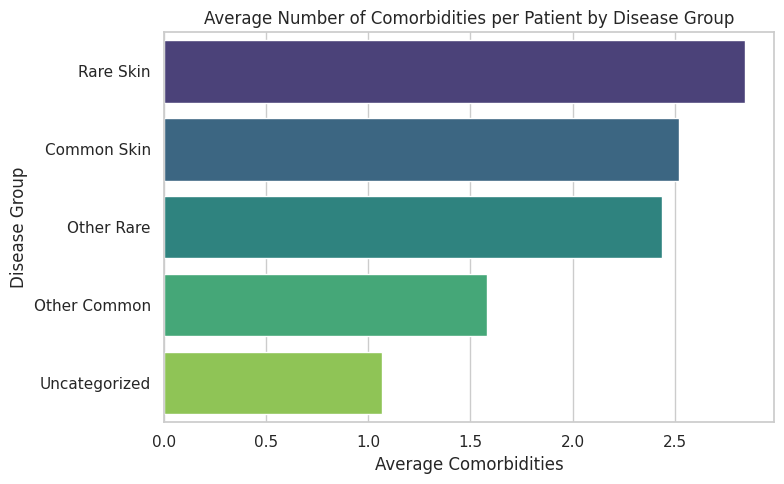

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(data=avg_comorbidity, x='comorbidity_count', y='disease_group', palette='viridis')

plt.title('Average Number of Comorbidities per Patient by Disease Group')
plt.xlabel('Average Comorbidities')
plt.ylabel('Disease Group')
plt.tight_layout()
plt.show()


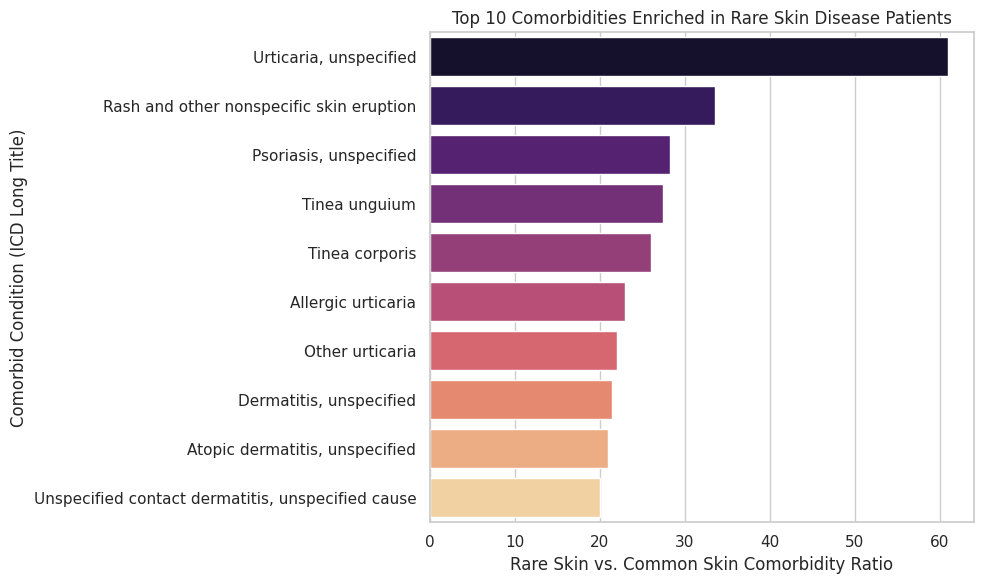

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 1: Filter dataset for rare skin (class 1) and common skin (class 2)
subset = df4[df4['class'].isin([1, 2])].copy()

# STEP 2: Parse icd_code_list into list of strings
subset['icd_code_list'] = subset['icd_code_list'].apply(
    lambda x: str(x).split(',') if pd.notnull(x) else []
)

# STEP 3: Explode the list into rows
exploded = subset.explode('icd_code_list')

# STEP 4: Rename and clean icd_code
exploded = exploded.rename(columns={'icd_code_list': 'icd_codes_from_list'})
exploded['icd_codes_from_list'] = exploded['icd_codes_from_list'].astype(str).str.strip()

# STEP 5: Count each icd_code per class
comorb_counts = (
    exploded.groupby(['class', 'icd_codes_from_list'])
    .size()
    .reset_index(name='count')
)

# STEP 6: Pivot
pivot = comorb_counts.pivot(index='icd_codes_from_list', columns='class', values='count').fillna(0)
pivot.columns = ['Common_Skin', 'Rare_Skin']  # class 2 = Common, class 1 = Rare
pivot = pivot.astype(int)

# STEP 7: Add totals and ratio
pivot['Total'] = pivot['Rare_Skin'] + pivot['Common_Skin']
pivot['Rare_vs_Common_Ratio'] = (pivot['Rare_Skin'] + 1) / (pivot['Common_Skin'] + 1)

# STEP 8: Merge with ICD long titles from df4
pivot = pivot.reset_index()
#pivot = pivot.merge(df4[['icd_codes_from_list', 'long_title']].drop_duplicates(), on='icd_codes_from_list', how='left')
pivot = pivot.merge(df4[['icd_code', 'long_title']].drop_duplicates(),
                    left_on='icd_codes_from_list',
                    right_on='icd_code',
                    how='left')


# STEP 9: Filter low-frequency codes
filtered = pivot[pivot['Total'] >= 20]

# STEP 10: Top 10 enriched in rare skin diseases
top10 = filtered.sort_values('Rare_vs_Common_Ratio', ascending=False).head(10)

# STEP 11: Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10,
    y='long_title',
    x='Rare_vs_Common_Ratio',
    palette='magma'
)
plt.xlabel('Rare Skin vs. Common Skin Comorbidity Ratio')
plt.ylabel('Comorbid Condition (ICD Long Title)')
plt.title('Top 10 Comorbidities Enriched in Rare Skin Disease Patients')
plt.tight_layout()
plt.show()

#This means these diseases co occur more with rare skin diseases than common skin diseases.

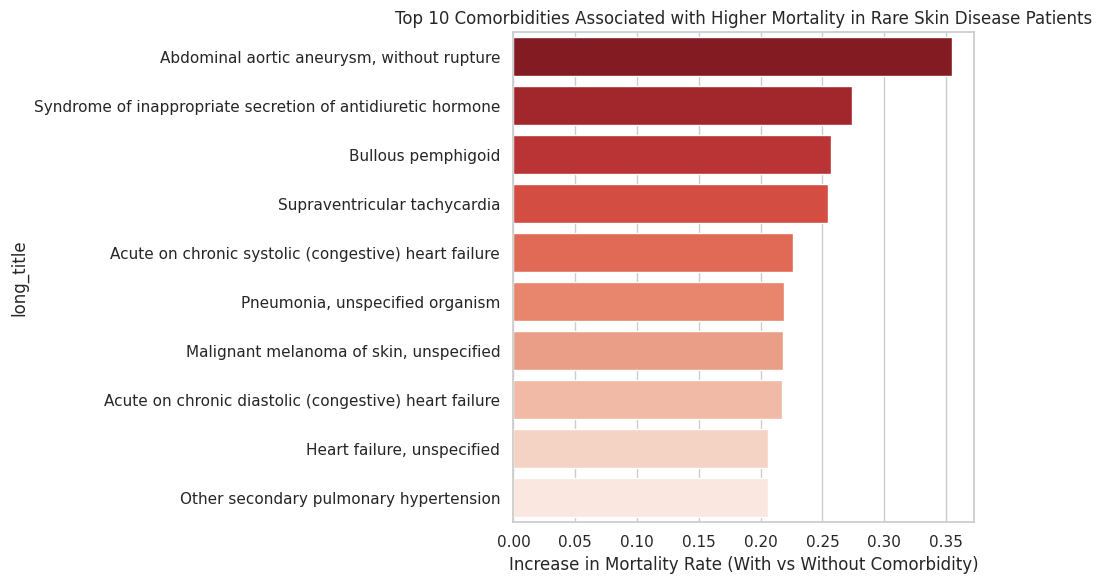

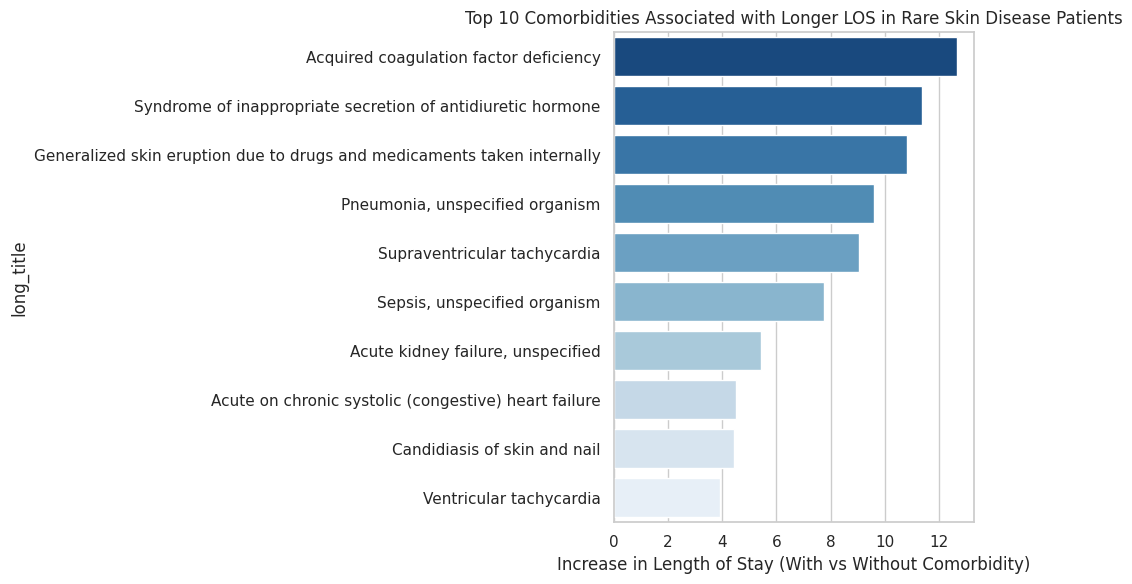

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Filter for rare skin disease patients only
rare_skin_df = df[df['class'] == 1].copy()

# Parse icd_code_list into lists
rare_skin_df['icd_code_list'] = rare_skin_df['icd_code_list'].apply(lambda x: str(x).split(',') if pd.notnull(x) else [])

# Get list of all comorbid ICD codes in rare skin patients
all_icd_codes = set(code.strip() for codes in rare_skin_df['icd_code_list'] for code in codes)

results = []

# Iterate over ICD codes to compare outcomes in patients WITH and WITHOUT the comorbidity
for icd in all_icd_codes:
    # Patients with this comorbidity
    with_comorb = rare_skin_df[rare_skin_df['icd_code_list'].apply(lambda codes: icd in [c.strip() for c in codes])]
    # Patients without this comorbidity
    without_comorb = rare_skin_df[rare_skin_df['icd_code_list'].apply(lambda codes: icd not in [c.strip() for c in codes])]

    # Skip if too few patients with comorbidity
    if len(with_comorb) < 20:
        continue

    # Mortality rates
    mort_with = with_comorb['is_dead'].mean()
    mort_without = without_comorb['is_dead'].mean()

    # LOS means
    los_with = with_comorb['los'].mean()
    los_without = without_comorb['los'].mean()

    # Statistical test for mortality difference (Mann-Whitney U test or similar)
    try:
        mort_stat, mort_p = mannwhitneyu(with_comorb['is_dead'], without_comorb['is_dead'])
    except:
        mort_p = 1

    # Statistical test for LOS difference
    try:
        los_stat, los_p = mannwhitneyu(with_comorb['los'], without_comorb['los'])
    except:
        los_p = 1

    results.append({
        'icd_code': icd,
        'mortality_with': mort_with,
        'mortality_without': mort_without,
        'mortality_diff': mort_with - mort_without,
        'mortality_pvalue': mort_p,
        'los_with': los_with,
        'los_without': los_without,
        'los_diff': los_with - los_without,
        'los_pvalue': los_p,
        'count_with': len(with_comorb)
    })

# Create results dataframe
results_df = pd.DataFrame(results)

# Merge ICD long titles if available
if 'long_title' in df.columns:
    icd_titles = df[['icd_code', 'long_title']].drop_duplicates()
    results_df = results_df.merge(icd_titles, left_on='icd_code', right_on='icd_code', how='left')

# Filter for comorbidities with statistically significant difference (p < 0.05)
sig_mortality = results_df[results_df['mortality_pvalue'] < 0.05].sort_values('mortality_diff', ascending=False).head(10)
sig_los = results_df[results_df['los_pvalue'] < 0.05].sort_values('los_diff', ascending=False).head(10)

# Plot top 10 comorbidities with highest mortality increase
plt.figure(figsize=(10,6))
sns.barplot(
    data=sig_mortality,
    x='mortality_diff',
    y='long_title' if 'long_title' in sig_mortality else 'icd_code',
    palette='Reds_r'
)
plt.xlabel('Increase in Mortality Rate (With vs Without Comorbidity)')
plt.title('Top 10 Comorbidities Associated with Higher Mortality in Rare Skin Disease Patients')
plt.tight_layout()
plt.show()

# Plot top 10 comorbidities with highest LOS increase
plt.figure(figsize=(10,6))
sns.barplot(
    data=sig_los,
    x='los_diff',
    y='long_title' if 'long_title' in sig_los else 'icd_code',
    palette='Blues_r'
)
plt.xlabel('Increase in Length of Stay (With vs Without Comorbidity)')
plt.title('Top 10 Comorbidities Associated with Longer LOS in Rare Skin Disease Patients')
plt.tight_layout()
plt.show()


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filter rare skin patients
rare_skin_df = df[df['class'] == 1].copy()

# 2. Create age groups BEFORE exploding
bins = [0, 18, 35, 50, 65, 80, 200]
labels = ['0-17', '18-34', '35-49', '50-64', '65-79', '80+']
rare_skin_df['age_group'] = pd.cut(rare_skin_df['anchor_age'], bins=bins, labels=labels, right=False)

# 3. Parse icd_code_list into lists
rare_skin_df['icd_code_list'] = rare_skin_df['icd_code_list'].apply(lambda x: str(x).split(',') if pd.notnull(x) else [])

# 4. Explode icd_code_list (rename exploded column to avoid conflict)
exploded = rare_skin_df.explode('icd_code_list').rename(columns={'icd_code_list': 'comorb_icd_code'})

# 5. Clean comorb_icd_code column and drop empty or null codes
exploded['comorb_icd_code'] = exploded['comorb_icd_code'].astype(str).str.strip()
exploded = exploded[exploded['comorb_icd_code'] != '']

# 6. Merge demographics columns (gender, age_group) if needed
exploded = exploded.merge(
    rare_skin_df[['subject_id', 'gender', 'age_group']],
    on='subject_id',
    how='left',
    suffixes=('', '_drop')
)

# Drop duplicate columns from merge
for col in exploded.columns:
    if col.endswith('_drop'):
        exploded.drop(columns=col, inplace=True)

# 7. Calculate prevalence of each comorbid ICD code by gender and age_group
grouped = (
    exploded.groupby(['gender', 'age_group', 'comorb_icd_code'])['subject_id']
    .nunique()
    .reset_index(name='count_with_comorb')
)

# 8. Total patients per gender and age_group
total_patients = (
    rare_skin_df.groupby(['gender', 'age_group'])['subject_id']
    .nunique()
    .reset_index(name='total_patients')
)

# 9. Merge total patients info
grouped = grouped.merge(total_patients, on=['gender', 'age_group'])

# 10. Calculate prevalence percentage
grouped['prevalence_pct'] = 100 * grouped['count_with_comorb'] / grouped['total_patients']

# 11. Get top 5 comorbidities per subgroup
top_comorbs_by_group = (
    grouped.sort_values(['gender', 'age_group', 'prevalence_pct'], ascending=[True, True, False])
    .groupby(['gender', 'age_group'])
    .head(5)
)

In [41]:
top_comorbs_by_group[top_comorbs_by_group['gender'] == 1]

gender age_group comorb_icd_code  count_with_comorb  total_patients  prevalence_pct
0          1      0-17            A150                  0               0             NaN
1          1      0-17            A170                  0               0             NaN
2          1      0-17            A182                  0               0             NaN
3          1      0-17            A310                  0               0             NaN
4          1      0-17           A4101                  0               0             NaN
601        1     18-34            L270                 24              63          38.095
435        1     18-34            D509                  7              63          11.111
678        1     18-34            N179                  7              63          11.111
381        1     18-34            B372                  5              63           7.937
526        1     18-34             I10                  4              63           6.349
962        1     35-49            L270                 30              77          38.961
1039       1     35-49            N179                 21              77          27.273
887        1     35-49             I10                 20              77          25.974
728        1     35-49            A419                  8              77          10.390
796        1     35-49            D509                  5              77           6.494
1248       1     50-64             I10                 77             182          42.308
1323       1     50-64            L270                 65             182          35.714
1400       1     50-64            N179                 32             182          17.582
1185       1     50-64            E119                 22             182          12.088
1212       1     50-64            E854                 18             182           9.890
1609       1     65-79             I10                 78             193          40.415
1684       1     65-79            L270                 57             193          29.534
1761       1     65-79            N179                 56             193          29.016
1573       1     65-79            E854                 52             193          26.943
1546       1     65-79            E119                 29             193          15.026
1934       1       80+            E854                 45             111          40.541
1970       1       80+             I10                 43             111          38.739
2122       1       80+            N179                 27             111          24.324
2045       1       80+            L270                 18             111          16.216
2008       1       80+            J449                 14             111          12.613

In [42]:
#Getting other rare diseases group that are frequently associated with rare skin diseases
df4[df4['class'] == 1]['Classification'].value_counts()

Classification
rare_skin_diseases                                                                                                                                                                                                                                                                    741
rare_genetic_diseases, rare_skin_diseases                                                                                                                                                                                                                                             102
rare_cardiac_diseases, rare_renal_diseases, rare_respiratory_diseases, rare_skin_diseases, rare_systemic_and_rheumatological_diseases, rare_systemic_and_rheumatological_diseases_of_childhood, rare_transplant-related_diseases                                                       80
rare_genetic_diseases, rare_immunological_diseases, rare_skin_diseases                                                                                                                                                                                                                 80
rare_abdominal_surgical_diseases, rare_developmental_anomalies_during_embryogenesis, rare_genetic_diseases, rare_odontological_diseases, rare_skin_diseases, rare_surgical_thoracic_diseases, rare_systemic_and_rheumatological_diseases                                               66
rare_neoplastic_diseases, rare_skin_diseases                                                                                                                                                                                                                                           65
rare_skin_diseases, rare_systemic_and_rheumatological_diseases                                                                                                                                                                                                                         59
rare_genetic_diseases, rare_neurological_diseases, rare_ophthalmic_diseases, rare_skin_diseases                                                                                                                                                                                        39
rare_developmental_anomalies_during_embryogenesis, rare_genetic_diseases, rare_neoplastic_diseases, rare_skin_diseases                                                                                                                                                                 38
rare_genetic_diseases, rare_neoplastic_diseases, rare_skin_diseases                                                                                                                                                                                                                    31
rare_genetic_diseases, rare_skin_diseases, rare_systemic_and_rheumatological_diseases, rare_systemic_and_rheumatological_diseases_of_childhood                                                                                                                                         17
rare_circulatory_system_diseases, rare_neurological_diseases, rare_ophthalmic_diseases, rare_renal_diseases, rare_skin_diseases, rare_systemic_and_rheumatological_diseases, rare_systemic_and_rheumatological_diseases_of_childhood, rare_transplant-related_diseases                 14
rare_circulatory_system_diseases, rare_developmental_anomalies_during_embryogenesis, rare_genetic_diseases, rare_hepatic_diseases, rare_neurological_diseases, rare_ophthalmic_diseases, rare_respiratory_diseases, rare_skin_diseases, rare_systemic_and_rheumatological_diseases     11
rare_neoplastic_diseases, rare_neurological_diseases, rare_skin_diseases                                                                                                                                                                                                               10
rare_developmental_anomalies_during_e

In [43]:
df4[df4['Classification']== 'rare_cardiac_diseases, rare_renal_diseases, rare_respiratory_diseases, rare_skin_diseases, rare_systemic_and_rheumatological_diseases, rare_systemic_and_rheumatological_diseases_of_childhood, rare_transplant-related_diseases']

subject_id   hadm_id                                 procedures_applied icd_code                       long_title  seq_num                                     Classification included  class  gender  anchor_age  anchor_year            admittime            dischtime  admission_type  admission_location  discharge_location  insurance  language  marital_status  race            edregtime            edouttime  hospital_expire_flag  is_first_admission  num_followups  future_rare_skin                             icd_code_list       next_admittime  days_to_next_admission  time_to_diagnosis  is_dead    los  admission_season  time_to_emergency_hrs  admit_month  is_night_admit  is_weekend_admit  total_no_of_procedures  no_of_unique_procedures  count_icu_critical_procedures    bmi bmi_chartdate  no_of_transfers  no_of_distinct_careunits  no_of_ed_transfers  first_careunit                         careunit_transfer_sequence  last_careunit  no_of_icu_stays  count_adt_orders  count_blood_bank  \
193      10030753  29563407                                                NaN     M341                 CR(E)ST syndrome       18  rare_cardiac_diseases, rare_renal_diseases, ra...     True      1       2          47         2190  2198-06-17 00:00:00  2198-06-18 16:12:00               5                   2                  14          1         1               3     1                  NaN                  NaN                     0                   1             24                 0                                 M341,G600  2198-07-07 22:14:00                  19.000              1.000        1  1.675                 3                    NaN            6               1                 1                       0                        0                              0 29.800    2198-07-08                1                         2                   0               5                   Medicine/Cardiology;Vascular;nan             11                0                 3                 0   
467      10081636  28854523  Excision of Stomach, Percutaneous Endoscopic A...     M341                 CR(E)ST syndrome       10  rare_cardiac_diseases, rare_renal_diseases, ra...     True      1       2          42         2165  2173-09-20 08:25:00  2173-09-21 18:00:00               6                   2                   1          1         1               1     1                  NaN                  NaN                     0                   1              0                 0                                 M341,M797                  NaN                  -1.000              1.000        0  1.399                 4                    NaN            9               0                 0                       2                        2                              2 47.400    2173-09-21                2                         3                   0               2                 Discharge Lounge;PACU;Medicine;nan              3                0                 3                 0   
537      10096046  27093118                                                NaN     M349  Systemic sclerosis, unspecified        8  rare_cardiac_diseases, rare_renal_diseases, ra...     True      1       2          82         2131  2138-02-24 23:33:00  2138-03-01 14:40:00               1                   2                   3          1         1               1     1  2138-02-24 15:16:00  2138-02-25 00:56:00                     0                   1              0                 0                           M349,I712,I5032                  NaN                  -1.000              1.000        0  4.630                 1                 -8.283            2               1                 0                       0                        0                              0 19.200    2138-02-17                2                         4                   1               3  Emergency Department;Medicine;Trauma SICU (TSI...              7                1                 5                 0   
1922   

In [44]:
#Getting other rare diseases group that are frequently associated with rare skin diseases
df4[df4['class'] == 1]['included'].value_counts()

included
True     839
Maybe    576
Name: count, dtype: int64

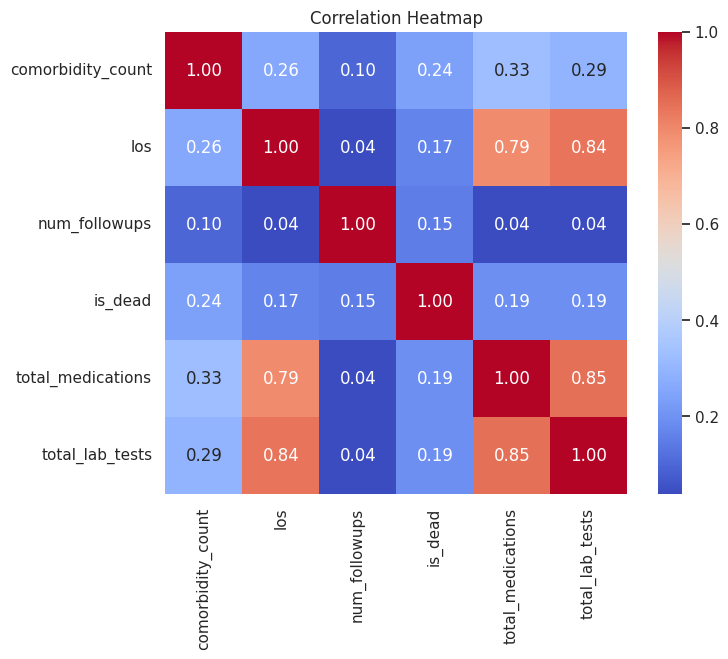

In [45]:
#Does comorbidity count correlate with these other columns?
# Select the relevant columns
cols_of_interest = ['comorbidity_count', 'los', 'num_followups', 'is_dead', 'total_medications', 'total_lab_tests']
subset_df4 = df4[cols_of_interest]
# Compute correlation matrix
corr_matrix = subset_df4.corr()
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.show()

## 5. Diagnostic journey of patients who weren't identified at first admission

In [46]:
df5[['future_rare_skin', 'class']].value_counts()

future_rare_skin  class
0                 4        28682
                  3        21615
                  2         2219
                  5         2176
                  1         1415
1                 3          372
                  4          351
                  2           61
                  5           26
Name: count, dtype: int64

In [47]:
# Crosstab of raw counts
ct = pd.crosstab(df5['future_rare_skin'], df5['class'])
# Transpose so classes are rows, then normalize row-wise
ct_percent_per_class = ct.T.div(ct.T.sum(axis=1), axis=0) * 100
# Transpose back to original format
ct_percent_per_class = ct_percent_per_class.T
# Print
print("Raw Counts:")
print(ct)
print("\nPercent Within Each Class (column %):")
print(ct_percent_per_class.round(2))


Raw Counts:
class                1     2      3      4     5
future_rare_skin                                
0                 1415  2219  21615  28682  2176
1                    0    61    372    351    26

Percent Within Each Class (column %):
class                  1      2      3      4      5
future_rare_skin                                    
0                100.000 97.320 98.310 98.790 98.820
1                  0.000  2.680  1.690  1.210  1.180


In [48]:
missed_patients = df5[df5['future_rare_skin'] == 1]

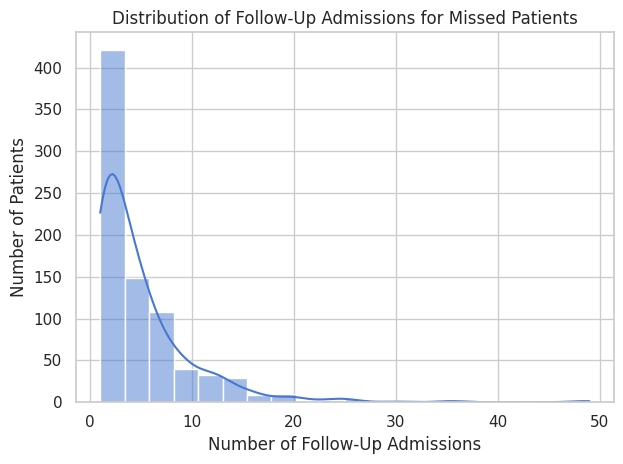

Median follow-ups (missed): 3.0
Max follow-ups (missed): 49


In [49]:
sns.histplot(data=missed_patients, x='num_followups', bins=20, kde=True)
plt.title('Distribution of Follow-Up Admissions for Missed Patients')
plt.xlabel('Number of Follow-Up Admissions')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()

# Summary stats
print("Median follow-ups (missed):", missed_patients['num_followups'].median())
print("Max follow-ups (missed):", missed_patients['num_followups'].max())

In [50]:
missed_patients.groupby('future_rare_skin')['num_followups'].describe()

count  mean   std   min   25%   50%   75%    max
future_rare_skin                                                   
1                810.000 5.005 5.180 1.000 2.000 3.000 6.000 49.000

/tmp/ipython-input-51-2530113295.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missed_patients['age_group'] = pd.cut(missed_patients['anchor_age'], bins=bins, labels=labels, right=False)


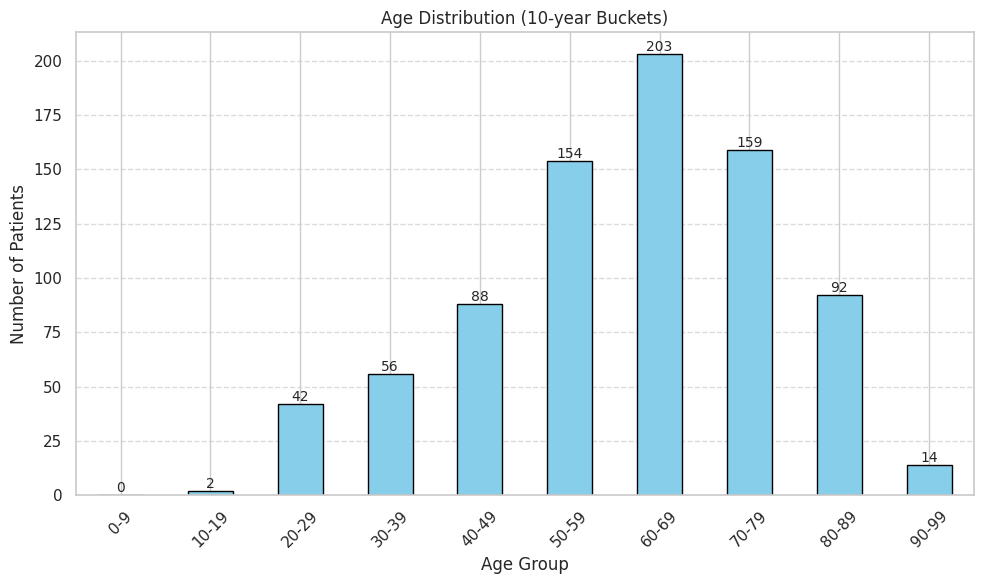

In [51]:
# Create age bins (e.g., 0–9, 10–19, ..., 90–99)
bins = range(0, 101, 10)
labels = [f"{i}-{i+9}" for i in bins[:-1]]

# Bin the ages
missed_patients['age_group'] = pd.cut(missed_patients['anchor_age'], bins=bins, labels=labels, right=False)

# Count values
age_counts = missed_patients['age_group'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10,6))
ax = age_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add count labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)

plt.title('Age Distribution (10-year Buckets)')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [52]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=d1ac6c5e50301d349899b6b47498f7cec42fcbb053a0893e20687a3eb1be9dad
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


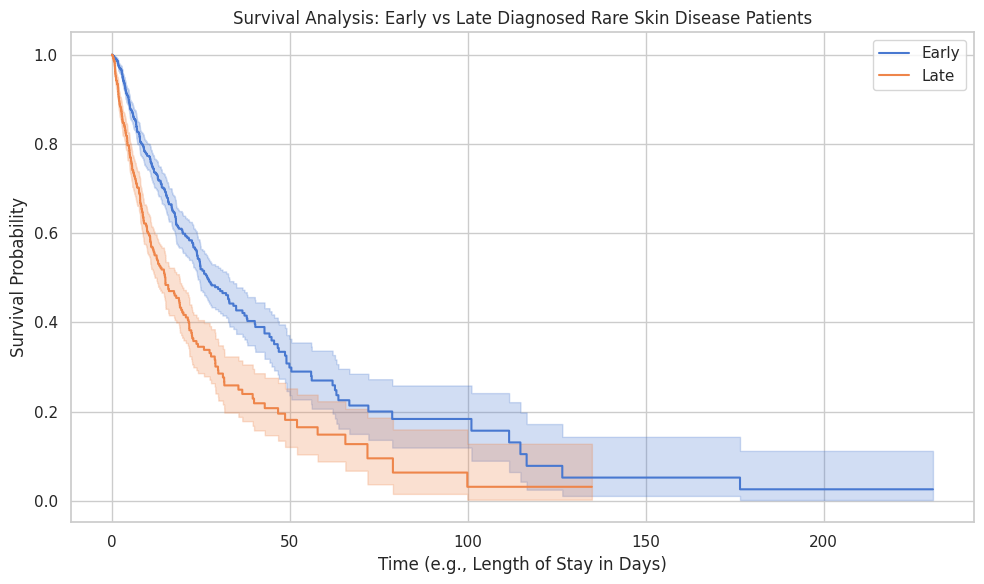

In [53]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Create the early vs. late diagnosed labels
df5['diagnosis_group'] = df5.apply(
    lambda row: 'Early' if row['class'] == 1 and row['future_rare_skin'] == 0
    else ('Late' if row['class'] != 1 and row['future_rare_skin'] == 1 else None),
    axis=1
)

# Filter for only early and late diagnosed rare skin disease patients
surv_df = df5[df5['diagnosis_group'].notnull()].copy()

# Check if 'length_of_stay' column exists, or use another proxy for time-to-event
# Assuming you have a time column like 'length_of_stay' in days
# Replace 'length_of_stay' with your actual time-to-event column
T = surv_df['los']  # time duration column
E = surv_df['is_dead'] # event occurred (1 = death, 0 = alive)

# Fit Kaplan-Meier estimator for both groups
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

for label in ['Early', 'Late']:
    group = surv_df[surv_df['diagnosis_group'] == label]
    kmf.fit(durations=group['los'], event_observed=group['is_dead'], label=label)
    kmf.plot_survival_function(ci_show=True)

plt.title('Survival Analysis: Early vs Late Diagnosed Rare Skin Disease Patients')
plt.xlabel('Time (e.g., Length of Stay in Days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.tight_layout()
plt.show()


Curve: Early-Diagnosed Patients
Starts at 1.0 and drops gradually over time. The curve declines slower compared to the "Late" group. At around 50 days, ~30% of early-diagnosed patients are still alive. Reaches a plateau between 100–150 days.

Curve: Late-Diagnosed Patients
Drops sharply in the first 20–40 days. Survival probability consistently lower than early-diagnosed group. Only ~20% survive past day 50. Very few survive beyond 100 days.

✅ 1. Early diagnosis is associated with better in-hospital survival
The blue curve (early-diagnosed) stays above the orange curve (late-diagnosed) for almost the entire length of stay.

This implies that early recognition and treatment of rare skin diseases leads to lower short-term mortality.

⚠️ 2. Late diagnosis correlates with higher risk of in-hospital death
The steeper drop in the orange curve suggests that patients diagnosed late deteriorate quickly and die earlier during hospitalization.

Diagnostic delay may result in missed opportunities for early intervention.

🧠 3. Clinical Implication
This provides evidence for advocating early recognition tools (e.g., ML decision support) in rare skin diseases to potentially improve outcomes.

📉 4. Confidence intervals
The shaded regions represent uncertainty.

They overlap slightly after day ~80–100, which could imply lower statistical power or fewer patients surviving that long.

In [54]:
#Co morbidities differing in comparison with labtests
# Add a diagnosis_group label
df5['diagnosis_group'] = df5.apply(
    lambda row: 'Early' if row['class'] == 1 and row['future_rare_skin'] == 0
    else ('Late' if row['class'] != 1 and row['future_rare_skin'] == 1 else None),
    axis=1
)

# Filter only early and late groups
lab_df = df5[df5['diagnosis_group'].isin(['Early', 'Late'])].copy()
# Automatically detect lab columns
lab_columns = [col for col in lab_df.columns if col.startswith(('first_value_'))]

from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd

# Store results
results = []

# Loop through each lab column
for col in lab_columns:
    early_vals = lab_df[lab_df['diagnosis_group'] == 'Early'][col].dropna()
    late_vals = lab_df[lab_df['diagnosis_group'] == 'Late'][col].dropna()

    # Use Mann-Whitney U test (non-parametric) for robustness
    if len(early_vals) > 20 and len(late_vals) > 20:  # only test if enough data
        stat, p = mannwhitneyu(early_vals, late_vals, alternative='two-sided')
        results.append({
            'lab': col,
            'early_mean': early_vals.mean(),
            'late_mean': late_vals.mean(),
            'p_value': p
        })

# Convert to DataFrame and sort
lab_diff_df = pd.DataFrame(results)
lab_diff_df['abs_diff'] = abs(lab_diff_df['early_mean'] - lab_diff_df['late_mean'])
lab_diff_df = lab_diff_df.sort_values(by='p_value')

# Show top results
lab_diff_df[['lab', 'early_mean', 'late_mean', 'abs_diff', 'p_value']].round(3).head(20)

lab  early_mean  late_mean  abs_diff  p_value
34                              first_value_ptt      33.160     33.666     0.506    0.001
17                          first_value_glucose     127.091    136.523     9.432    0.002
41                           first_value_sodium     138.431    138.007     0.424    0.003
38                              first_value_rdw      14.741     14.977     0.236    0.004
23            first_value_immature_granulocytes       0.861      0.736     0.125    0.012
9   first_value_asparate_aminotransferase_(ast)      76.570     66.083    10.487    0.017
31                        first_value_monocytes       7.942      8.641     0.699    0.023
15                       first_value_creatinine       1.177      1.320     0.143    0.027
20                       first_value_hemoglobin      11.213     11.027     0.186    0.044
8                         first_value_anion_gap      14.897     15.187     0.290    0.045
5    first_value_alanine_aminotransferase_(alt)      66.525     54.247    12.278    0.054
39                           first_value_rdw-sd      48.442     49.069     0.627    0.058
44                first_value_white_blood_cells      11.094     10.227     0.867    0.060
35                        first_value_phosphate       3.547      3.622     0.075    0.061
1         first_value_absolute_eosinophil_count       0.197      0.250     0.053    0.086
14                         first_value_chloride     101.821    101.471     0.350    0.091
40                  first_value_red_blood_cells       3.798      3.753     0.045    0.102
11                      first_value_bicarbonate      23.750     24.003     0.253    0.103
30                        first_value_magnesium       1.969      1.944     0.024    0.109
19                       first_value_hematocrit      34.311     33.906     0.405    0.113

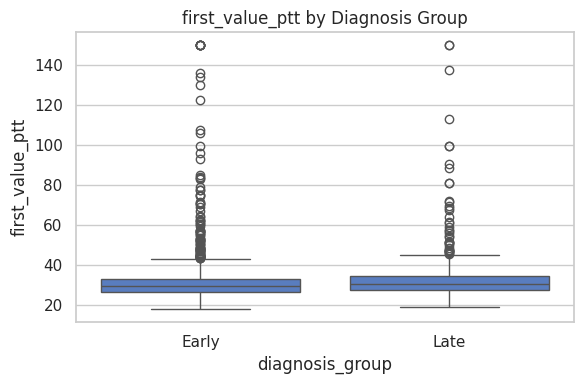

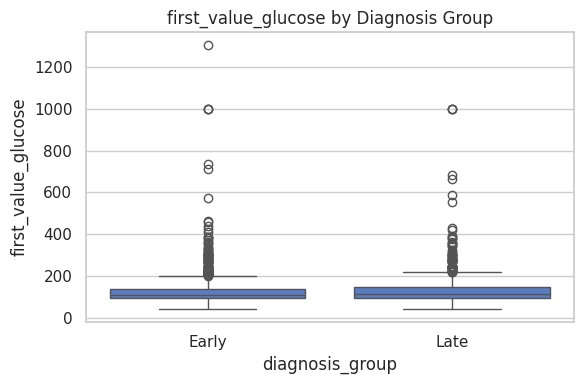

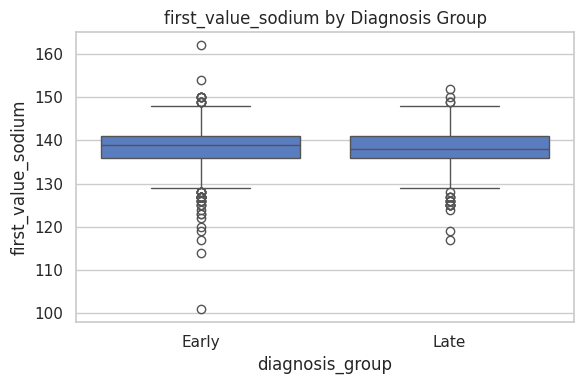

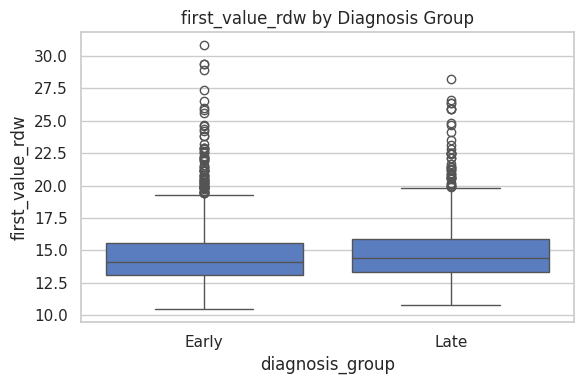

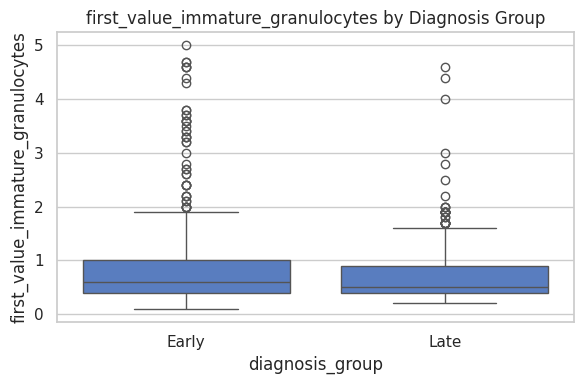

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

top_labs = lab_diff_df.head(5)['lab'].tolist()

for lab in top_labs:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=lab_df, x='diagnosis_group', y=lab)
    plt.title(f'{lab} by Diagnosis Group')
    plt.tight_layout()
    plt.show()

Are ICU transfers more common in Late diagnosed vs Early diagnosed?

In [56]:
df5[df5['diagnosis_group'] == 'Early']['no_of_icu_stays'].value_counts()

no_of_icu_stays
0    959
1    398
2     50
3      5
4      3
Name: count, dtype: int64

In [57]:
df5[df5['diagnosis_group'] == 'Late']['no_of_icu_stays'].value_counts()

no_of_icu_stays
0    649
1    142
2     16
3      3
Name: count, dtype: int64

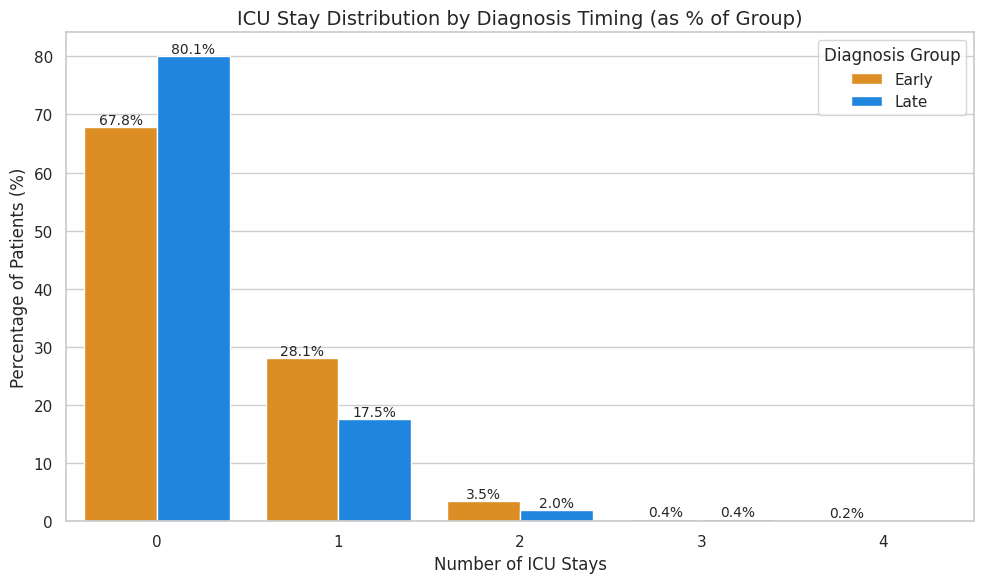

In [58]:
# Filter for Early and Late groups
icu_data = df5[df5['diagnosis_group'].isin(['Early', 'Late'])]
# Count and compute percentage
icu_counts = icu_data.groupby(['diagnosis_group', 'no_of_icu_stays']).size().reset_index(name='count')
icu_counts['percentage'] = icu_counts.groupby('diagnosis_group')['count'].transform(lambda x: x / x.sum() * 100)
# Set custom colors
custom_palette = {'Early': '#fb9204', 'Late': '#0087ff'}
# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=icu_counts,
    x='no_of_icu_stays',
    y='percentage',
    hue='diagnosis_group',
    palette=custom_palette
)
# Add percentage labels on top of bars
for container in ax.containers:
    ax.bar_label(container, labels=[f'{h:.1f}%' for h in container.datavalues], fontsize=10, label_type='edge')
# Aesthetics
plt.title('ICU Stay Distribution by Diagnosis Timing (as % of Group)', fontsize=14)
plt.xlabel('Number of ICU Stays', fontsize=12)
plt.ylabel('Percentage of Patients (%)', fontsize=12)
plt.legend(title='Diagnosis Group')
plt.tight_layout()
plt.show()

Demographic Differences between early and late diagnosed patients.

In [59]:
# Bin age into categories
df5['age_group'] = pd.cut(df5['anchor_age'], bins=[0, 18, 35, 50, 65, 80, 120],
                          labels=['0-18', '19-35', '36-50', '51-65', '66-80', '80+'])

def plot_percentage_bars(df, group_col, hue_col, title):
    # Filter Early and Late
    demo_data = df[df['diagnosis_group'].isin(['Early', 'Late'])]

    # Count and convert to %
    counts = demo_data.groupby([group_col, hue_col]).size().reset_index(name='count')
    counts['percentage'] = counts.groupby(group_col)['count'].transform(lambda x: x / x.sum() * 100)

    # Plot
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=counts, x=hue_col, y='percentage', hue=group_col, palette='viridis')

    # Add % labels
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{v:.1f}%' for v in container.datavalues], fontsize=9, label_type='edge')

    plt.title(title, fontsize=14)
    plt.xlabel(hue_col.capitalize(), fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.legend(title='Diagnosis Group')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

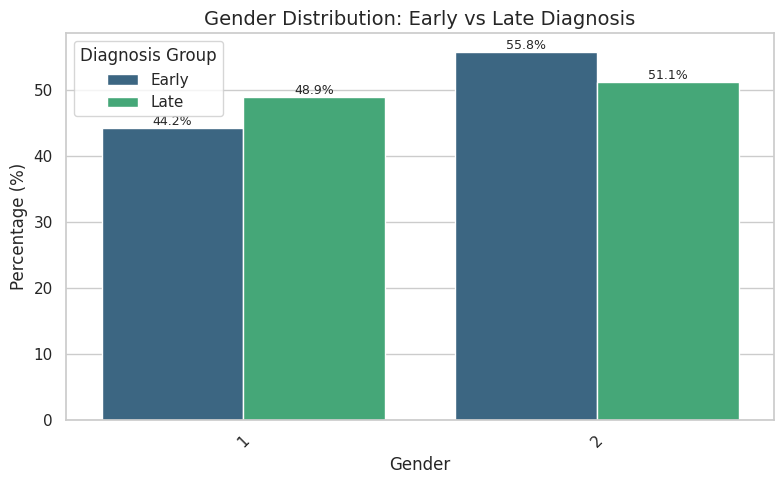

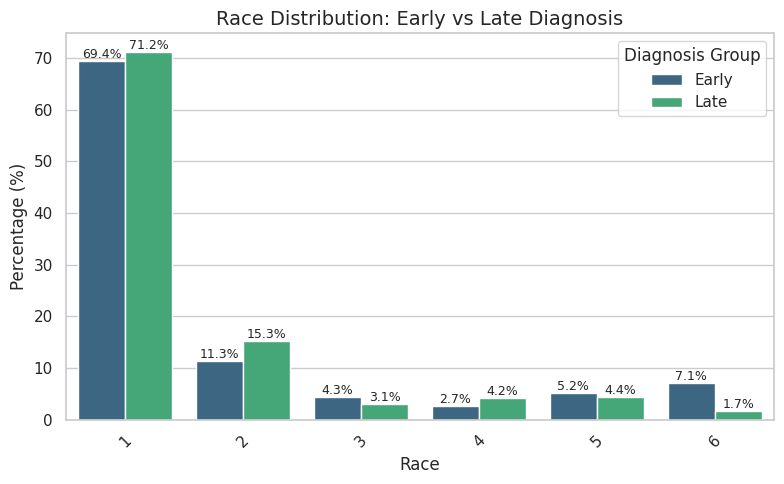

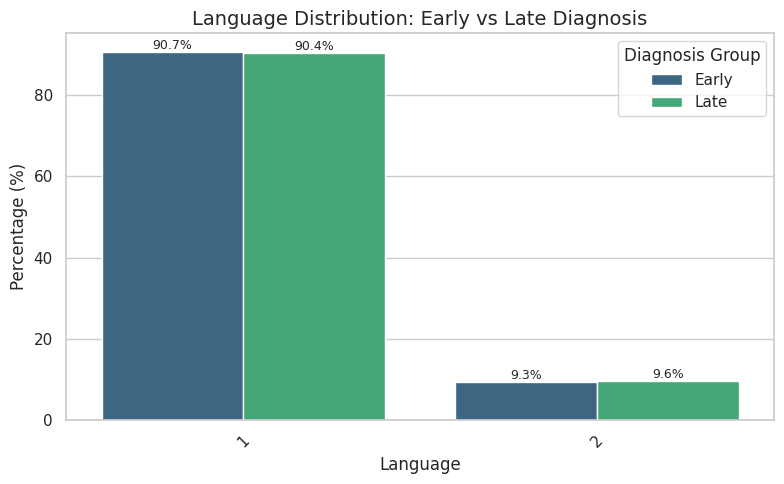

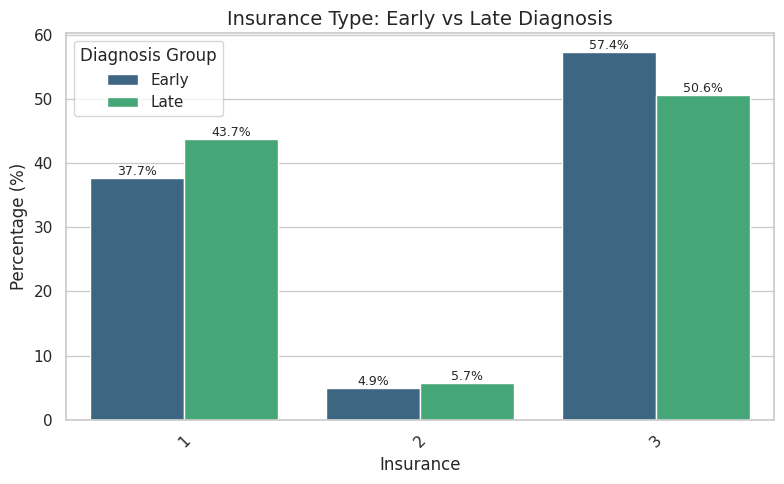

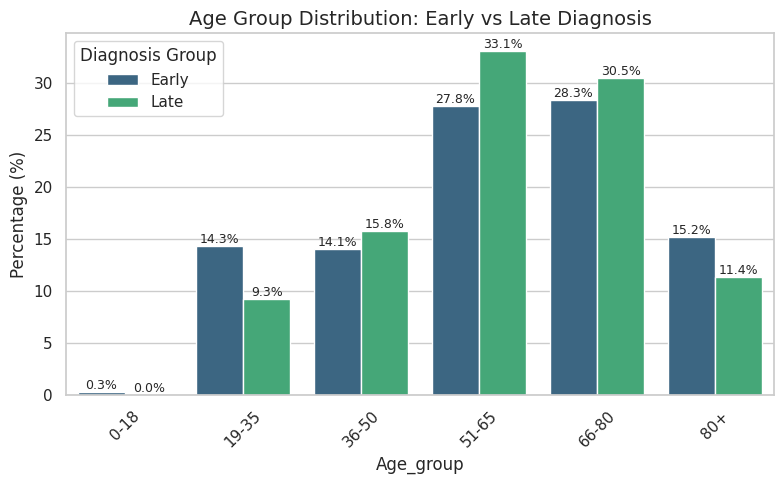

In [60]:
plot_percentage_bars(df5, 'diagnosis_group', 'gender', 'Gender Distribution: Early vs Late Diagnosis')
plot_percentage_bars(df5, 'diagnosis_group', 'race', 'Race Distribution: Early vs Late Diagnosis')
plot_percentage_bars(df5, 'diagnosis_group', 'language', 'Language Distribution: Early vs Late Diagnosis')
plot_percentage_bars(df5, 'diagnosis_group', 'insurance', 'Insurance Type: Early vs Late Diagnosis')
plot_percentage_bars(df5, 'diagnosis_group', 'age_group', 'Age Group Distribution: Early vs Late Diagnosis')

In [61]:
import scipy.stats as stats
pd.crosstab(df5['gender'], df5['diagnosis_group'], normalize='columns')  # Proportions
# Example: Chi-square test for gender
contingency = pd.crosstab(df5['gender'], df5['diagnosis_group'])
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f"Chi-square p-value for gender vs diagnosis group: {p:.4f}")

Chi-square p-value for gender vs diagnosis group: 0.0382


## 6. Phenotype sub-grouping of rare skin diseases

In [62]:
#Getting cleaned dataset for clustering
case2dataset = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/case_2_dataset.csv')

In [63]:
case2dataset.head()

subject_id   hadm_id  seq_num  class  gender  anchor_age  anchor_year  admission_type  admission_location  discharge_location  insurance  language  marital_status  race  hospital_expire_flag  is_first_admission  num_followups  future_rare_skin  days_to_next_admission  time_to_diagnosis  is_dead   los  admission_season  time_to_emergency_hrs  admit_month  is_night_admit  is_weekend_admit  no_of_unique_procedures  count_icu_critical_procedures    bmi  no_of_transfers  no_of_distinct_careunits  no_of_ed_transfers  first_careunit  last_careunit  no_of_icu_stays  count_adt_orders  count_blood_bank  count_cardiology  count_consults  count_critical_care  count_general_care  count_hemodialysis  count_iv_therapy  count_neurology  count_nutrition  count_ob  count_radiology  count_respiratory  count_tpn  count_abscess  count_blood_culture  count_sputum  count_stool  count_swab  count_tissue  count_urine  total_microbiologyevents  positive_cultures  resistant_tests  route_eyes  route_iv  \
0    10000117  22927623        7      5       2          48         2174               3                   1                  14          3         1               3     1                     0                   1              1                 0                 672.000              0.000        0 0.533                 4                 -4.233           11               1                 0                        0                              0 17.000                1                         3                   1              13              7                0                 4                 0                 0               0                    0                   5                   0                 1                0                4         0                2                  0          0              0                    0             0            0           0             0            0                         0                  0                0           0         1   
1    10002266  24160398        3      1       2          31         2124               4                   2                   1          3         1               1     1                     0                   1              0                 0                  -1.000              1.000        0 5.939                 1                  0.000            2               0                 0                        2                              1 24.700                3                         2                   0              12             12                0                 4                 1                 0               0                    0                  16                   0                 6                0                3         1                0                  0          0              0                    0             0            0           0             0            0                         0                  0                0           0         7   
2    10002800  21095886       17      5       2          32         2164               4                   2                   1          3         1               3     1                     0                   1              0                 0                  -1.000              0.000        0 4.215                 3                  0.000            7               0                 0                        3                              0 36.500                1                         2                   0              12             12                0                 4                 1                 0               1                    0                  12                   0                 8                0                2         1                0                  0          0              0                    0             0            0           0             0            0                         0                  0                0           0        10   
3    10003385  2304

#### 6.1 Labs based phenotype sub grouping

In [64]:
case2dataset1 = case2dataset[case2dataset['class'] == 1]
case2dataset2 = case2dataset[case2dataset['class'] == 2]

/tmp/ipython-input-65-2215766084.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case2dataset1['lab_phenotype'] = cluster_labels


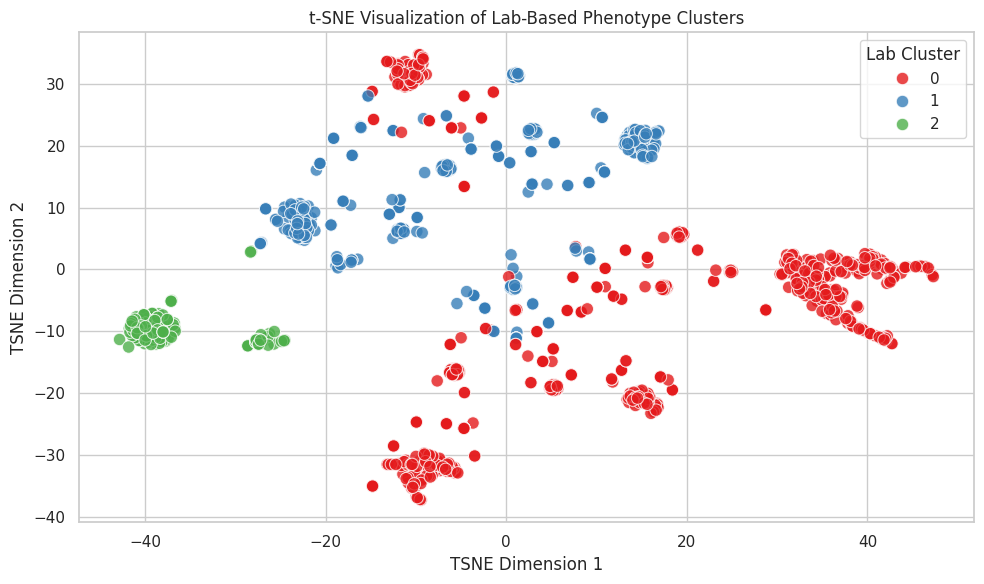

In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid", palette="Set1")

# --- 1. Select first lab values ---
lab_cols = [col for col in case2dataset1.columns if col.startswith('first_value_')]
lab_data = case2dataset1[lab_cols].copy()

# --- 2. Standardize the lab values ---
scaler = StandardScaler()
lab_data_scaled = scaler.fit_transform(lab_data)

# --- 3. Perform KMeans clustering with k=3 ---
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(lab_data_scaled)
case2dataset1['lab_phenotype'] = cluster_labels

# --- 4. t-SNE visualization of clusters ---
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
lab_data_tsne = tsne.fit_transform(lab_data_scaled)

tsne_df = pd.DataFrame(lab_data_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set1', s=80, alpha=0.8)
plt.title('t-SNE Visualization of Lab-Based Phenotype Clusters')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.legend(title='Lab Cluster')
plt.tight_layout()
plt.show()

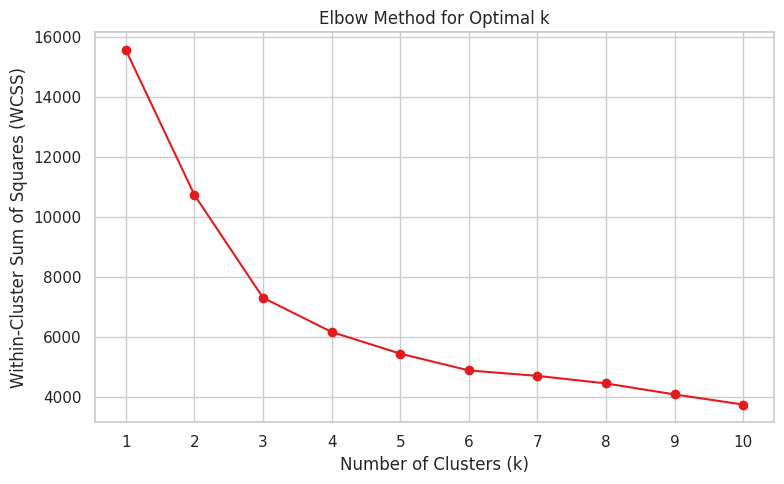

In [66]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(lab_data_scaled)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 11))
plt.grid(True)
plt.tight_layout()
plt.show()

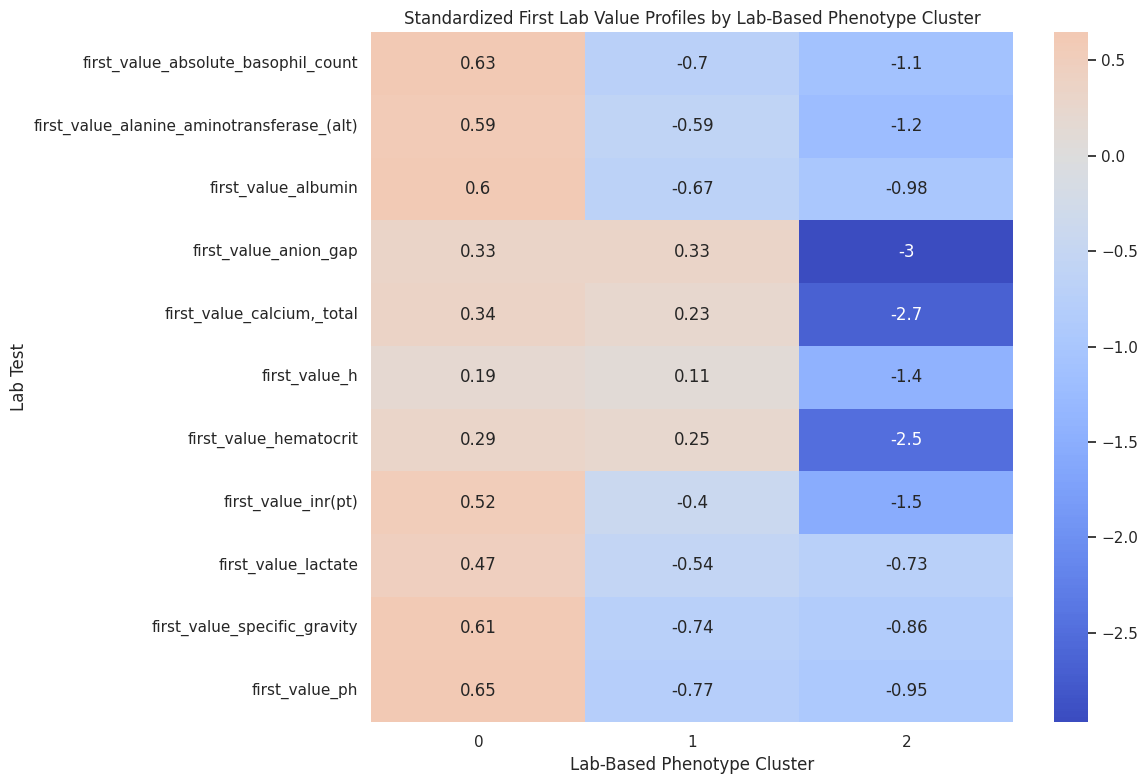

In [67]:
# --- Heatmap of average standardized lab profiles per cluster ---
cluster_means_df = pd.DataFrame(lab_data_scaled, columns=lab_cols)
cluster_means_df['lab_phenotype'] = cluster_labels
cluster_profile = cluster_means_df.groupby('lab_phenotype').mean().T

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profile, cmap='coolwarm', center=0, annot=True)
plt.title('Standardized First Lab Value Profiles by Lab-Based Phenotype Cluster')
plt.xlabel('Lab-Based Phenotype Cluster')
plt.ylabel('Lab Test')
plt.tight_layout()
plt.show()

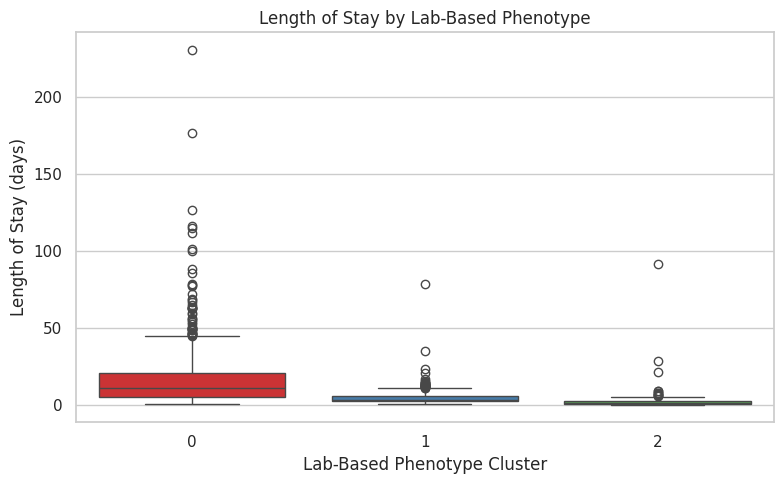

In [68]:
# --- Boxplot: Length of stay across clusters ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=case2dataset1, x='lab_phenotype', y='los', palette='Set1')
plt.title('Length of Stay by Lab-Based Phenotype')
plt.xlabel('Lab-Based Phenotype Cluster')
plt.ylabel('Length of Stay (days)')
plt.tight_layout()
plt.show()

/tmp/ipython-input-69-696441586.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case2dataset2['lab_phenotype'] = cluster_labels


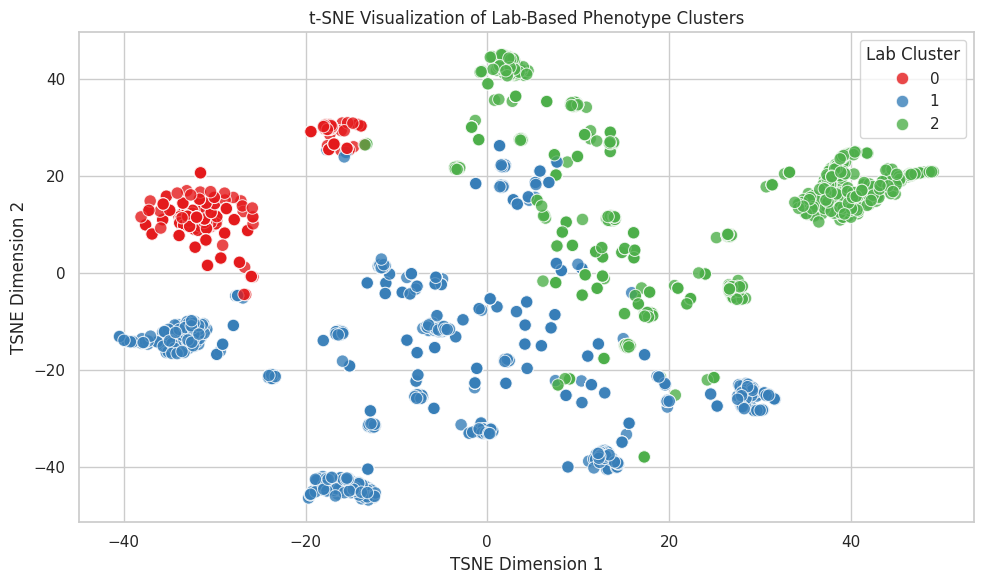

In [69]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid", palette="Set1")

# --- 1. Select first lab values ---
lab_cols = [col for col in case2dataset2.columns if col.startswith('first_value_')]
lab_data = case2dataset2[lab_cols].copy()

# --- 2. Standardize the lab values ---
scaler = StandardScaler()
lab_data_scaled = scaler.fit_transform(lab_data)

# --- 3. Perform KMeans clustering with k=3 ---
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(lab_data_scaled)
case2dataset2['lab_phenotype'] = cluster_labels

# --- 4. t-SNE visualization of clusters ---
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
lab_data_tsne = tsne.fit_transform(lab_data_scaled)

tsne_df = pd.DataFrame(lab_data_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set1', s=80, alpha=0.8)
plt.title('t-SNE Visualization of Lab-Based Phenotype Clusters')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.legend(title='Lab Cluster')
plt.tight_layout()
plt.show()

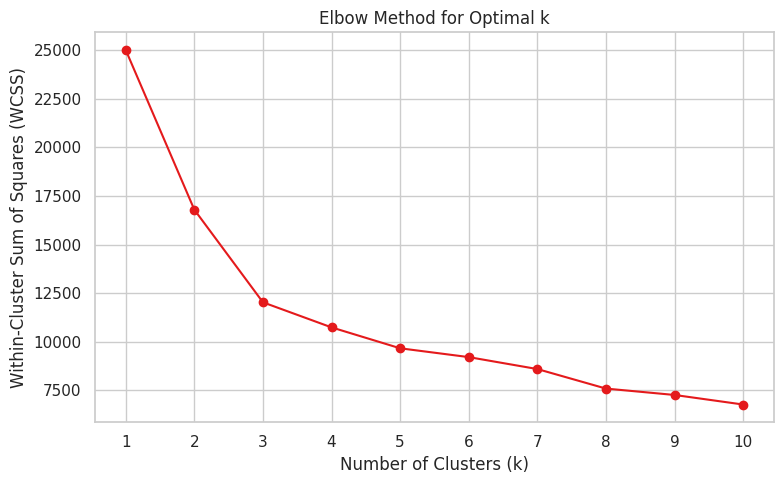

In [70]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(lab_data_scaled)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 11))
plt.grid(True)
plt.tight_layout()
plt.show()

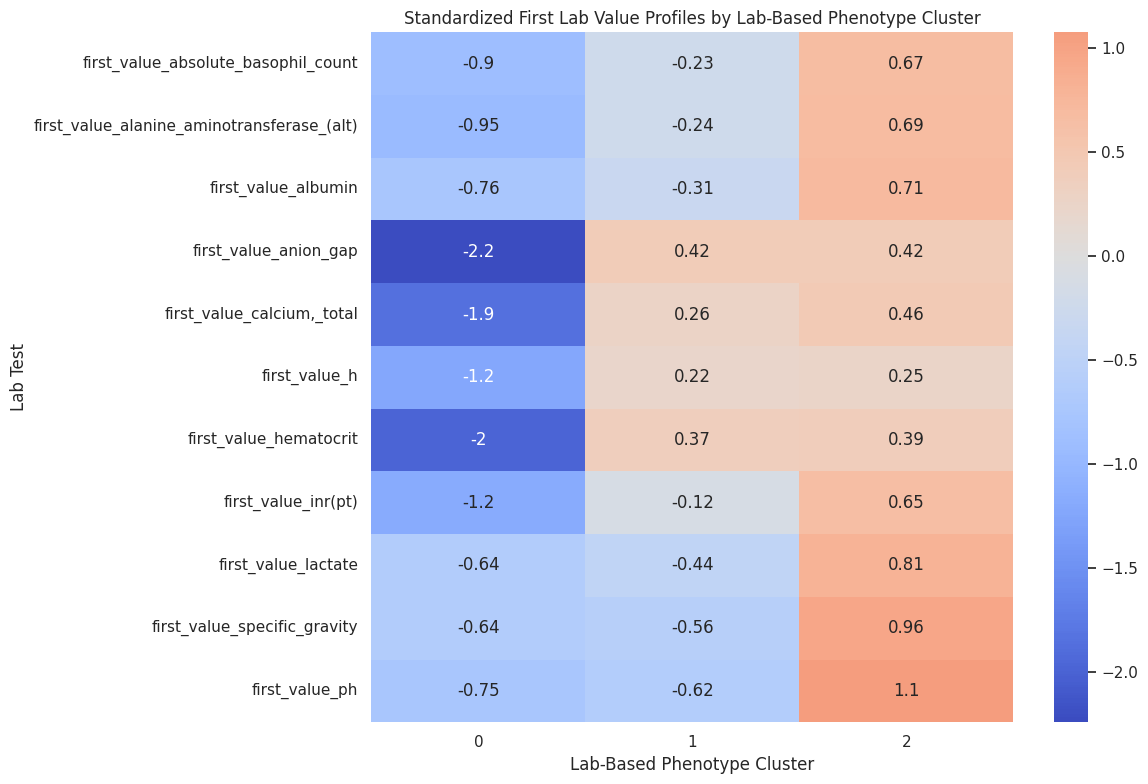

In [71]:
# --- Heatmap of average standardized lab profiles per cluster ---
cluster_means_df = pd.DataFrame(lab_data_scaled, columns=lab_cols)
cluster_means_df['lab_phenotype'] = cluster_labels
cluster_profile = cluster_means_df.groupby('lab_phenotype').mean().T

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profile, cmap='coolwarm', center=0, annot=True)
plt.title('Standardized First Lab Value Profiles by Lab-Based Phenotype Cluster')
plt.xlabel('Lab-Based Phenotype Cluster')
plt.ylabel('Lab Test')
plt.tight_layout()
plt.show()

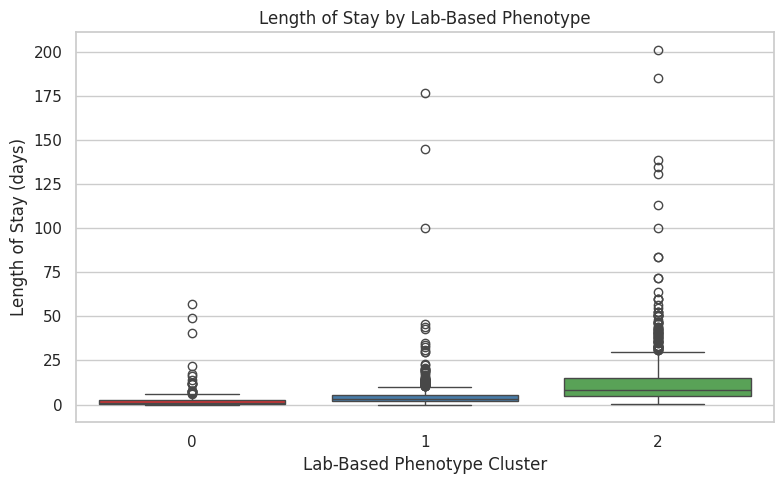

In [72]:
# --- Boxplot: Length of stay across clusters ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=case2dataset2, x='lab_phenotype', y='los', palette='Set1')
plt.title('Length of Stay by Lab-Based Phenotype')
plt.xlabel('Lab-Based Phenotype Cluster')
plt.ylabel('Length of Stay (days)')
plt.tight_layout()
plt.show()

#### 6.2 Medication based phenotype sub grouping

/tmp/ipython-input-73-2832514970.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case2dataset1['lab_phenotype'] = cluster_labels


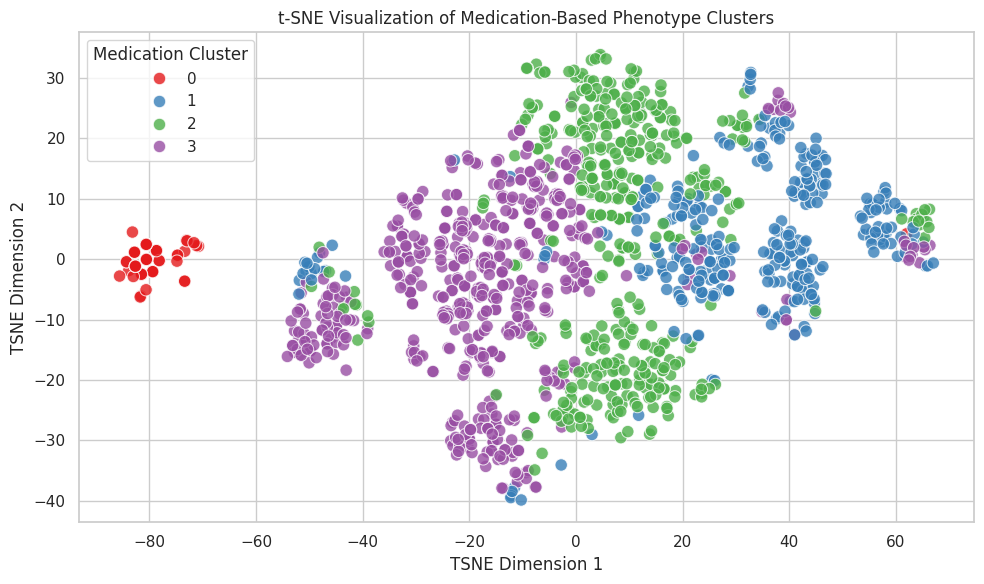

In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid", palette="Set1")

# --- 1. Select medication values ---
exclude_cols = [
    'has_abnormal_electrolyte_fluid',
    'has_abnormal_glucose_metabolic',
    'has_abnormal_hematologic',
    'has_abnormal_metabolic_acidbase',
    'has_abnormal_rbc_indices',
    'has_abnormal_renal'
]

# Step 2: Create lab_cols excluding the unwanted columns
lab_cols = [col for col in case2dataset1.columns if col.startswith('has_') and col not in exclude_cols]
lab_data = case2dataset1[lab_cols].copy()

# --- 2. Standardize the lab values ---
scaler = StandardScaler()
lab_data_scaled = scaler.fit_transform(lab_data)

# --- 3. Perform KMeans clustering with k=3 ---
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(lab_data_scaled)
case2dataset1['lab_phenotype'] = cluster_labels

# --- 4. t-SNE visualization of clusters ---
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
lab_data_tsne = tsne.fit_transform(lab_data_scaled)

tsne_df = pd.DataFrame(lab_data_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set1', s=80, alpha=0.8)
plt.title('t-SNE Visualization of Medication-Based Phenotype Clusters')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.legend(title='Medication Cluster')
plt.tight_layout()
plt.show()

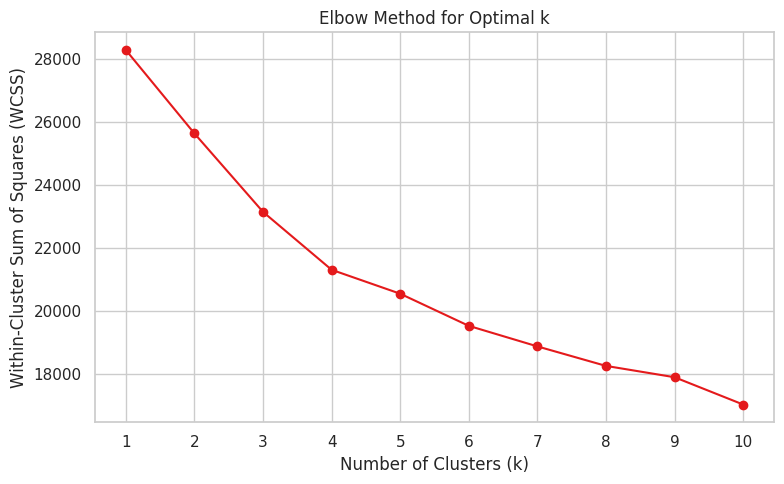

In [74]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(lab_data_scaled)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 11))
plt.grid(True)
plt.tight_layout()
plt.show()

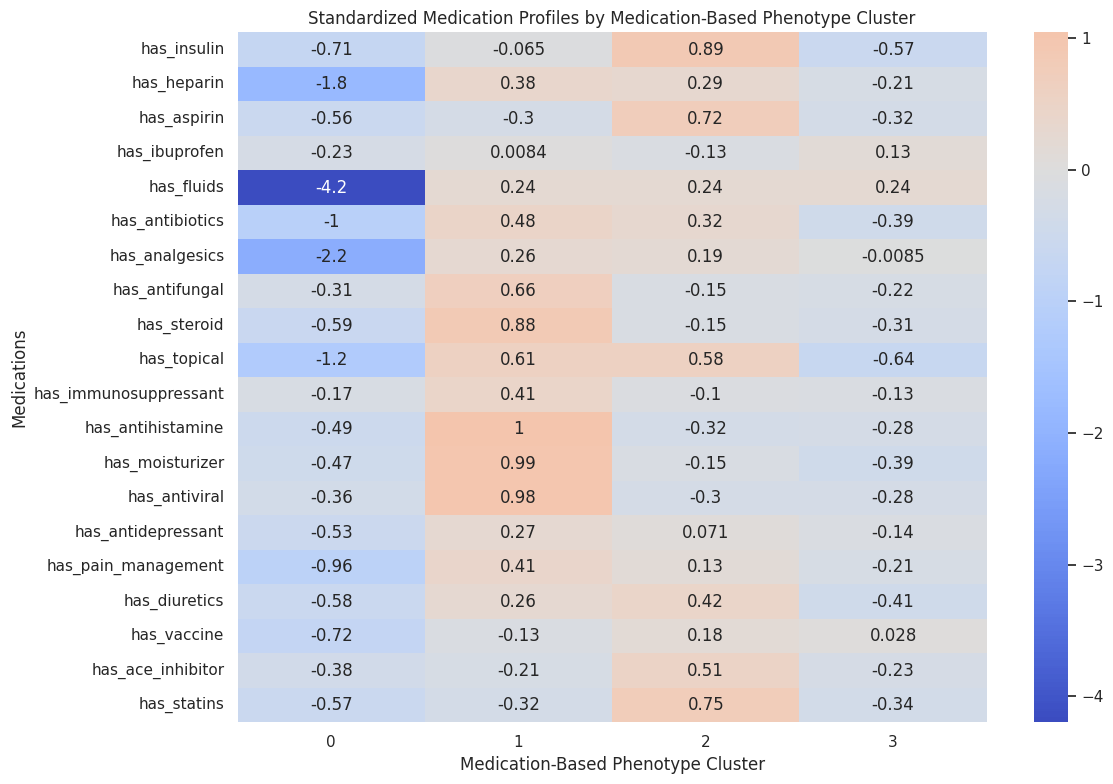

In [75]:
# --- Heatmap of average standardized lab profiles per cluster ---
cluster_means_df = pd.DataFrame(lab_data_scaled, columns=lab_cols)
cluster_means_df['lab_phenotype'] = cluster_labels
cluster_profile = cluster_means_df.groupby('lab_phenotype').mean().T

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profile, cmap='coolwarm', center=0, annot=True)
plt.title('Standardized Medication Profiles by Medication-Based Phenotype Cluster')
plt.xlabel('Medication-Based Phenotype Cluster')
plt.ylabel('Medications')
plt.tight_layout()
plt.show()

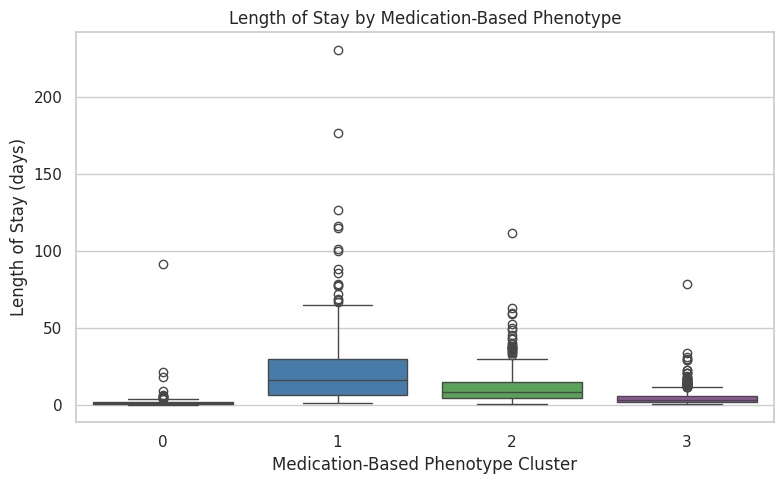

In [76]:
# --- Boxplot: Length of stay across clusters ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=case2dataset1, x='lab_phenotype', y='los', palette='Set1')
plt.title('Length of Stay by Medication-Based Phenotype')
plt.xlabel('Medication-Based Phenotype Cluster')
plt.ylabel('Length of Stay (days)')
plt.tight_layout()
plt.show()

#### 6.3 Utilization based phenotype sub grouping

/tmp/ipython-input-77-2204307615.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case2dataset1['util_phenotype'] = util_labels


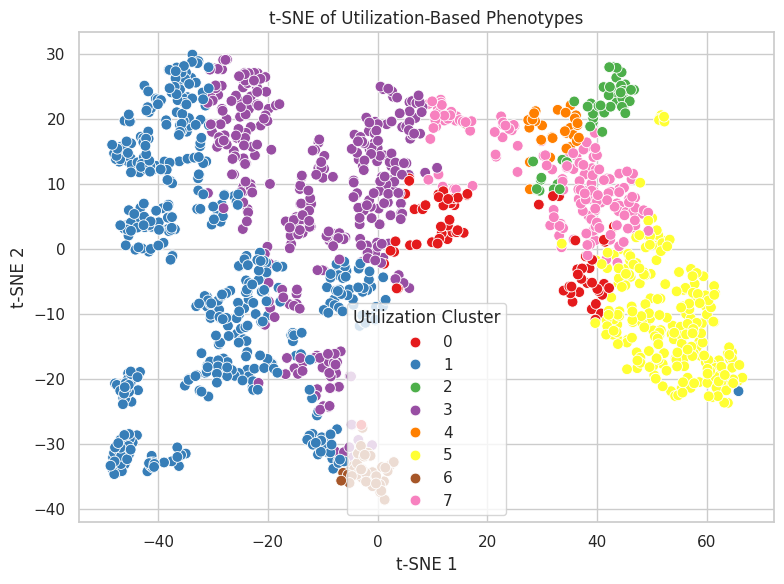

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# 1. Select utilization-related columns
util_cols = [
    'los',
    'num_followups',
    'no_of_unique_procedures',
    'no_of_transfers',
    'no_of_icu_stays',
    'unique_medications',
    'unique_lab_types'
    # Add more if available like 'num_procedures', 'num_transfers'
]

util_data = case2dataset1[util_cols].copy()

# 2. Standardize
scaler = StandardScaler()
util_scaled = scaler.fit_transform(util_data)

# 3. KMeans Clustering (set k = 3 or tune as needed)
kmeans = KMeans(n_clusters=8, random_state=42)
util_labels = kmeans.fit_predict(util_scaled)

# 4. Add cluster labels to dataframe
case2dataset1['util_phenotype'] = util_labels

# 5. t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_results = tsne.fit_transform(util_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=util_labels, palette='Set1', s=60)
plt.title('t-SNE of Utilization-Based Phenotypes')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Utilization Cluster')
plt.tight_layout()
plt.show()


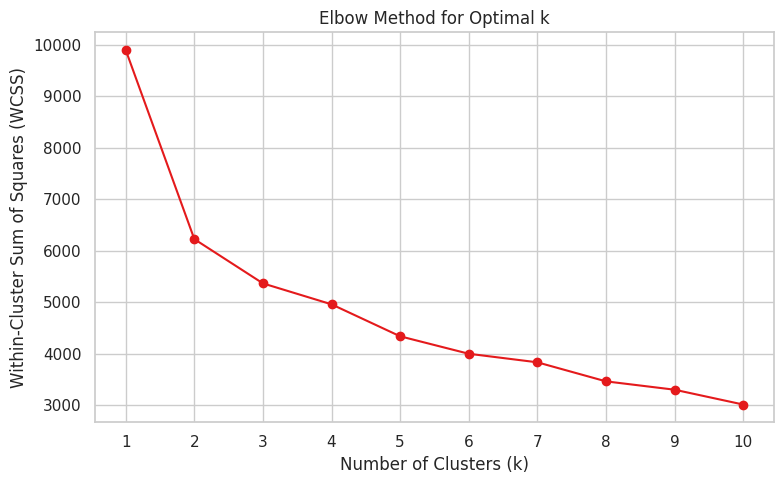

In [78]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(util_scaled)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 11))
plt.grid(True)
plt.tight_layout()
plt.show()

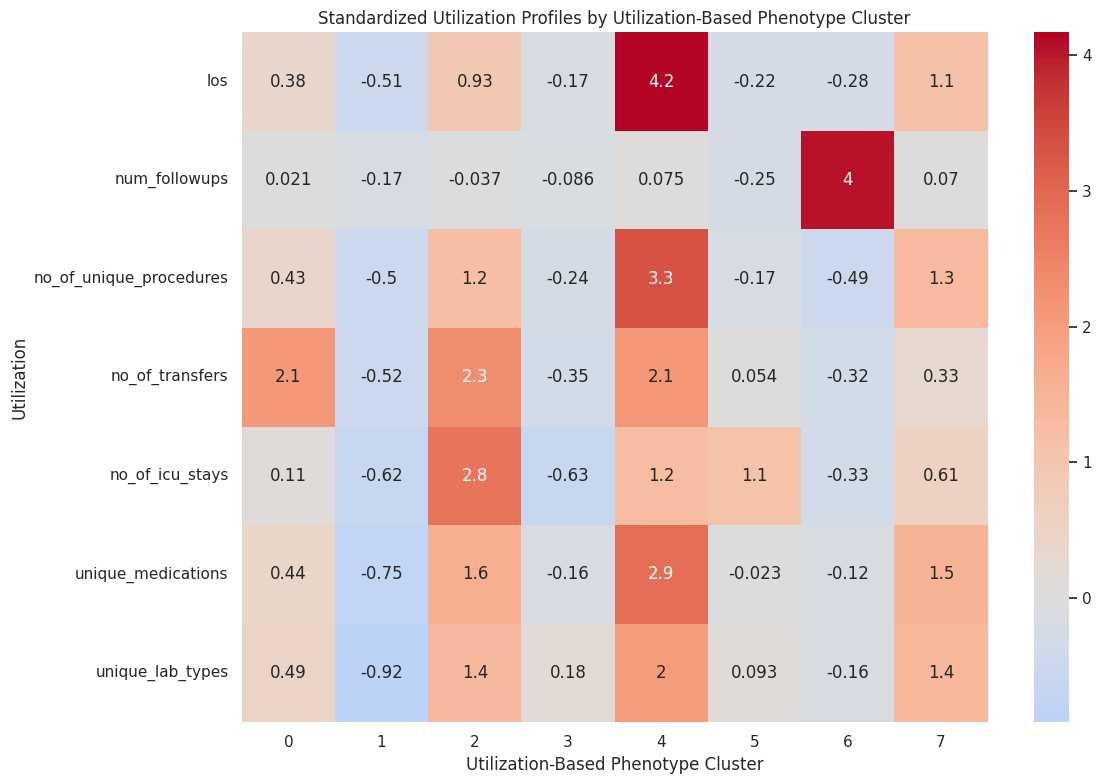

In [79]:
# --- Heatmap of average standardized lab profiles per cluster ---
cluster_means_df = pd.DataFrame(util_scaled, columns=util_cols)
cluster_means_df['util_phenotype'] = util_labels
cluster_profile = cluster_means_df.groupby('util_phenotype').mean().T

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profile, cmap='coolwarm', center=0, annot=True)
plt.title('Standardized Utilization Profiles by Utilization-Based Phenotype Cluster')
plt.xlabel('Utilization-Based Phenotype Cluster')
plt.ylabel('Utilization')
plt.tight_layout()
plt.show()

## 7. Do rare skin diseases patients have few structured medical records?

In [80]:
df7.head(3)

subject_id   hadm_id procedures_applied icd_code                                         long_title  seq_num                                     Classification included  class  gender  anchor_age  anchor_year            admittime            dischtime  admission_type  admission_location  discharge_location  insurance  language  marital_status  race            edregtime            edouttime  hospital_expire_flag  is_first_admission  num_followups  future_rare_skin icd_code_list       next_admittime  days_to_next_admission  time_to_diagnosis  is_dead   los  admission_season  time_to_emergency_hrs  admit_month  is_night_admit  is_weekend_admit  total_no_of_procedures  no_of_unique_procedures  count_icu_critical_procedures    bmi bmi_chartdate  no_of_transfers  no_of_distinct_careunits  no_of_ed_transfers  first_careunit                         careunit_transfer_sequence  last_careunit  no_of_icu_stays  count_adt_orders  count_blood_bank  count_cardiology  count_consults  \
0    10000084  29888819                NaN      G20                                Parkinson's disease        2  rare_genetic_diseases, rare_neurological_diseases     True      3       1          72         2160  2160-12-28 05:11:00  2160-12-28 16:07:00               3                   2                  14          1         1               1     1  2160-12-27 18:32:00  2160-12-28 16:07:00                     0                   1              0                 0           G20                  NaN                  -1.000              0.000        1 0.456                 1                -10.650           12               1                 1                       0                        0                              0 24.400    2160-11-21                0                         2                   1              13  Emergency Department;Emergency Department Obse...             13                0                 1                 0                 0               0   
1    10000117  22927623                NaN     I341               Nonrheumatic mitral (valve) prolapse        7                                      Uncategorised     True      5       2          48         2174  2181-11-15 02:05:00  2181-11-15 14:52:00               3                   1                  14          3         1               3     1  2181-11-14 21:51:00  2181-11-15 09:57:00                     0                   1              1                 0          I341  2183-09-18 18:10:00                 672.000              0.000        0 0.533                 4                 -4.233           11               1                 0                       0                        0                              0 17.000    2181-11-15                1                         3                   1              13  Emergency Department;Emergency Department Obse...              7                0                 4                 0                 0               0   
2    10000980  25911675                NaN    I5023  Acute on chronic systolic (congestive) heart f...        2                                    common_diseases     True      4       2          73         2186  2191-05-23 15:33:00  2191-05-24 17:14:00               2                   1                   2          1         1               1     2  2191-05-22 16:06:00  2191-05-23 17:56:00                     0                   1              2                 0         I5023  2191-07-16 14:21:00                  52.000              0.000        1 1.070                 2                -23.450            5               0                 0                       0                        0                              0 28.600    2191-05-23                0                         2                   1               3                  Emergency Department;Medicine;nan              3                0                 5                 0                 0               1   

   count_critical_care  count_general_care  count_hemo

Structured records in EHRs refer to discrete, standardized clinical entries like lab test results, medication administrations, procedures, and encounter events. We included total_lab_tests, total_medications, total_no_of_procedures, and num_followups as proxies for structured record volume because they represent objective, quantifiable interactions documented in the system. Rather than focusing on missing values in individual fields—which may be missing by design—we assess the overall presence and density of structured records to gauge how comprehensively patients are captured in the data.

We define structured medical records as standardized, discrete clinical entries that reflect a patient's interaction with the healthcare system. These include not just routine labs and medications, but also microbiology investigations, procedures, follow-ups, transfers, and ICU stays. Specifically, we use the following features as proxies for structured record volume: total_lab_tests, total_medications, total_no_of_procedures, num_followups, total_microbiologyevents, no_of_transfers, and no_of_icu_stays. These metrics collectively reflect both the breadth and depth of a patient’s documented clinical journey.

<Figure size 1400x700 with 0 Axes>

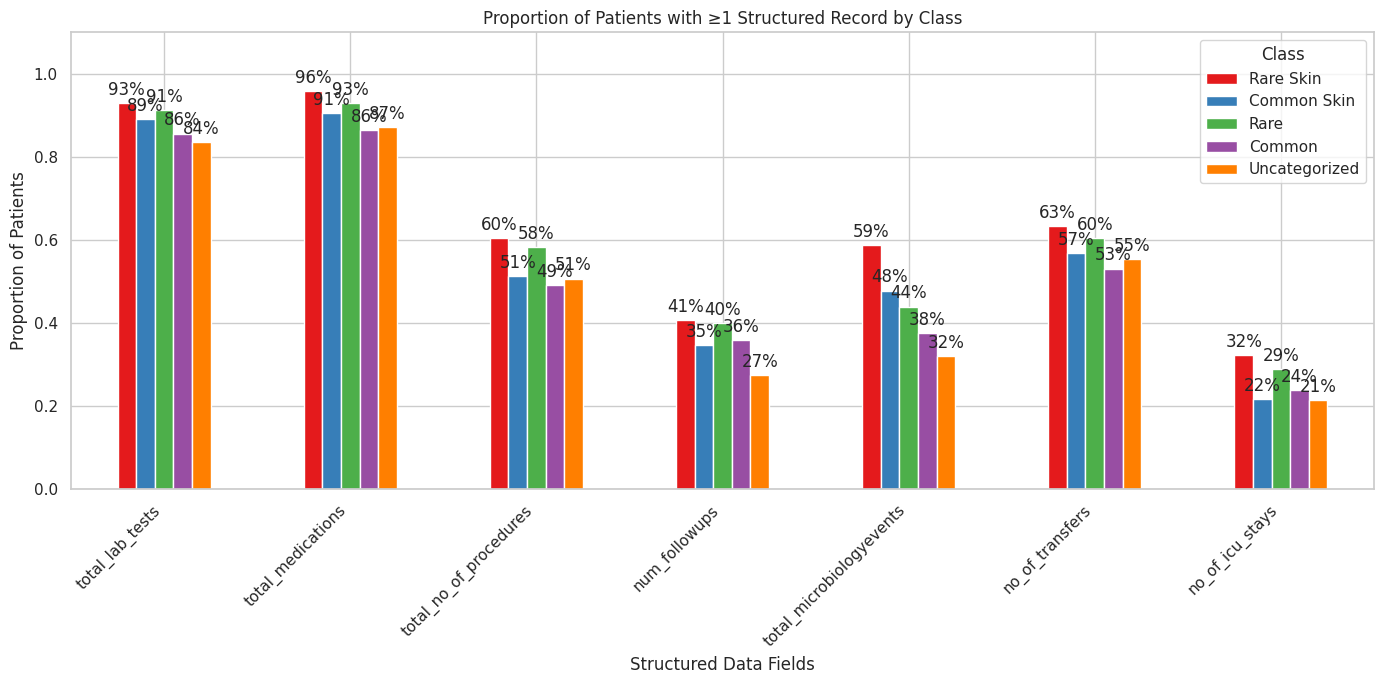

In [81]:
#Columns representing structured medical records
cols_to_check = [
    'total_lab_tests',
    'total_medications',
    'total_no_of_procedures',
    'num_followups',
    'total_microbiologyevents',
    'no_of_transfers',
    'no_of_icu_stays'
]

# Step 1: Create boolean mask: True = ≥1 structured record
binary_df = df7[cols_to_check] > 0

# Step 2: Group by class and compute proportion of patients with ≥1 record
proportion_df = binary_df.groupby(df7['class']).mean()  # shape: class x features

# Step 3: Plot
plt.figure(figsize=(14, 7))
ax = proportion_df.T.plot(kind='bar', figsize=(14, 7))

# Add percentages on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%', label_type='edge', padding=3,
                 labels=[f'{100*v:.0f}%' for v in container.datavalues])

# Customize plot
plt.title("Proportion of Patients with ≥1 Structured Record by Class")
plt.ylabel("Proportion of Patients")
plt.xlabel("Structured Data Fields")
plt.ylim(0, 1.1)  # make space for labels
plt.xticks(rotation=45, ha='right')
plt.legend(title="Class", labels=['Rare Skin', 'Common Skin', 'Rare', 'Common', 'Uncategorized'])
plt.tight_layout()
plt.show()


## 8. Admission and Discharge location status

In [82]:
# Step 1: Mapping dictionaries
admission_map = {
    1: 'EMERGENCY ROOM',
    2: 'PHYSICIAN REFERRAL',
    3: 'TRANSFER FROM HOSPITAL',
    4: 'WALK-IN/SELF REFERRAL',
    5: 'CLINIC REFERRAL',
    6: 'INTERNAL TRANSFER TO OR FROM PSYCH',
    7: 'TRANSFER FROM SKILLED NURSING FACILITY',
    8: 'AMBULATORY SURGERY TRANSFER',
    9: 'PROCEDURE SITE',
    10: 'PACU',
    11: 'INFORMATION NOT AVAILABLE'
}

discharge_map = {
    1: 'HOME',
    2: 'HOME HEALTH CARE',
    3: 'SKILLED NURSING FACILITY',
    4: 'DIED',
    5: 'REHAB',
    6: 'HOSPICE',
    7: 'CHRONIC/LT CARE',
    8: 'AGAINST ADVICE',
    9: 'ACUTE HOSPITAL',
    10: 'PSYCH FACILITY',
    11: 'OTHER FACILITY',
    12: 'ASSISTED LIVING',
    13: 'HEALTHCARE FACILITY',
    14: 'UNKNOWN'
}

# Step 2: Decode columns
df7['admission_loc'] = df7['admission_location'].map(admission_map)
df7['discharge_loc'] = df7['discharge_location'].map(discharge_map)

# Step 3: Set class labels
class_labels = ['Rare Skin', 'Common Skin', 'Rare', 'Common', 'Uncategorized']

# Step 4: Calculate % for admission and discharge
admission_pct = pd.crosstab(df7['class'], df7['admission_loc'], normalize='index') * 100
discharge_pct = pd.crosstab(df7['class'], df7['discharge_loc'], normalize='index') * 100

admission_pct.index = class_labels
discharge_pct.index = class_labels

# Step 5: Filter columns with low total % across all classes (e.g., < 3%)
admission_pct = admission_pct.loc[:, admission_pct.sum() > 3]
discharge_pct = discharge_pct.loc[:, discharge_pct.sum() > 3]

# Helper function to plot bar chart with % labels
def plot_with_labels(df, title, ylabel):
    ax = df.T.plot(kind='bar', figsize=(16, 7))
    for container in ax.containers:
        labels = [f'{val:.0f}%' if val > 1 else '' for val in container.datavalues]
        ax.bar_label(container, labels=labels, label_type='edge', fontsize=9, padding=2)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Location")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, df.to_numpy().max() + 10)
    plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



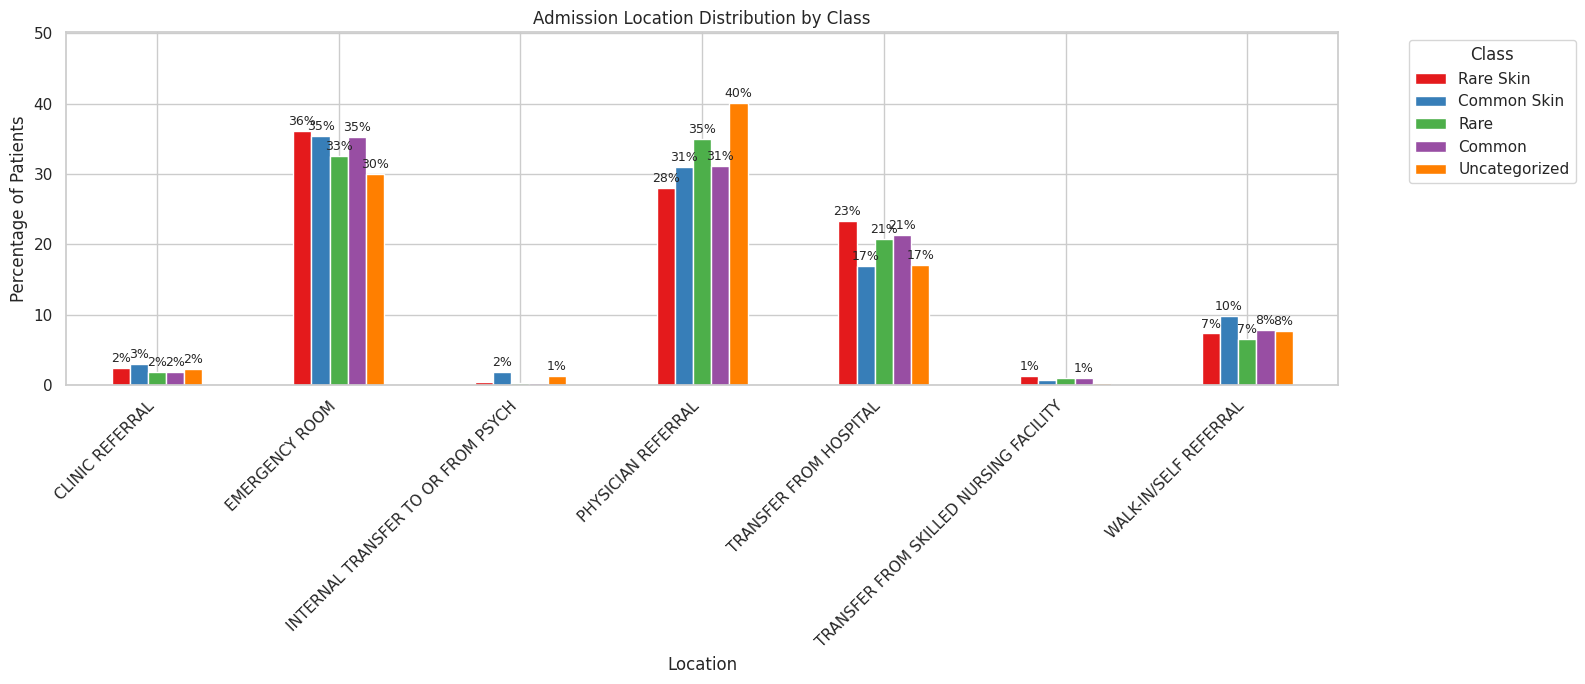

In [83]:
#Plot admission
plot_with_labels(admission_pct, "Admission Location Distribution by Class", "Percentage of Patients")

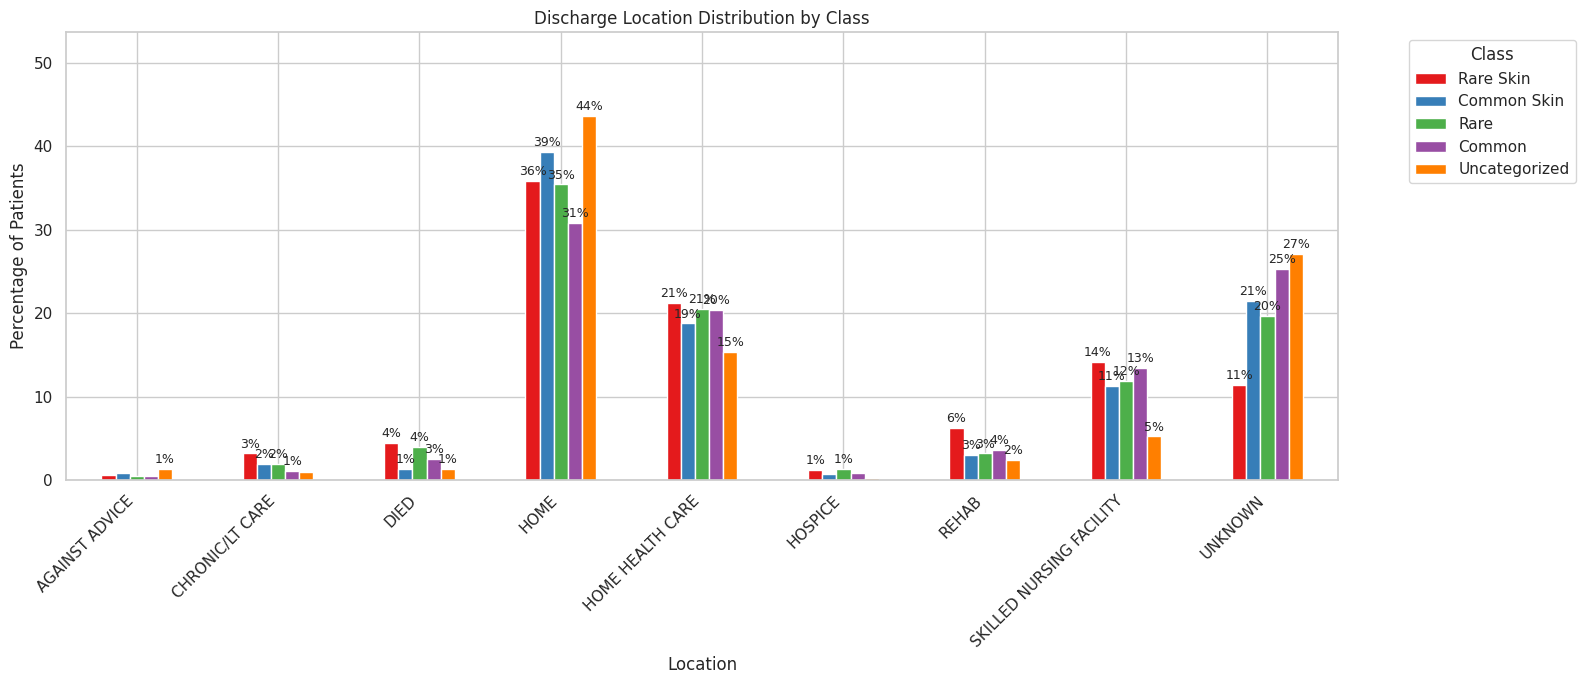

In [84]:
#Plot Discharge
plot_with_labels(discharge_pct, "Discharge Location Distribution by Class", "Percentage of Patients")